In [1]:
#IMPORTING LIBRARIES

import scipy.special as sp # UNUSED?
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import matplotlib.pyplot as plt # Provides a MATLAB-like way of plotting
import pandas as pd # Data analysis and manipulation tool. Used to read in bathymetry data (M77T file), Directions data (excel file), and organises Vmean into a labelled data structure
# M77T data files are created from raw data collected by marine researchers using InfoBank
from scipy.interpolate import CubicSpline as SP # Used to create a spline about the velocity, shape parameter and proability data
from scipy.optimize import minimize,least_squares,Bounds,basinhopping # Optimizing and route finding
from scipy.special import gamma # Gamma function used for weibull distribution
import matplotlib.cm as cm # UNUSED?
from Boruvka_Mod import Graph # imports class graph from Boruvka_Mod python file
import utm # Used to help convert latitude and longitude in bathymetry data to centred eastings and northings
import scipy.interpolate as spline # Used to smooth the bathymetry data
from matplotlib.colors import ListedColormap # UNUSED?
import math # Provides access to the mathematical functions
from time import perf_counter # Returns the float value of time in seconds. Used to record run time for clustering and optimization algorithms
from minmax_kmeans import minsize_kmeans # imports minsize_kmeans function from minmax_kmeans python file
import pulp #Used in the clustering algorithm to generate MPS and LP files
import scipy.signal as signal 
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline, BSpline
from scipy.spatial import ConvexHull

In [2]:
# KEY PARAMETERS USED THROUGHOUT MODEL

a = 625 # minimum distances turbines can be from one another in m.
b = 3000 # distance that turbines have negligible affect on eachother in m. If model changes this value could change

maximumturbinespertree = 10 # number of turbines allowed along a single cable from the substation.
budget = np.float64(200000000) # Budget in £ to build the wind farm, accounting for construction costs.
DistanceToShore = 15000 # m #distance of the wind farm from shore
TooCloseShore = 5000 # m # minimum distance the wind farm must be from shore
xCoordOnshoreSub = 0 # x coordinate of the onshore substation (y coordinate is -(DistanceToShore))

USDtoGBP = 1/1.351  
EURtoGBP = 1/1.19

IACableCostperMeter = 409.2*EURtoGBP
ExportCableCostperMeter = 833.625*EURtoGBP

CostperTurbineUSD = np.float64(3000000) # USD
CostperTurbine = CostperTurbineUSD*USDtoGBP # GBP

OperatingandMaintenanceCostsperAnnum = np.float64(65500) # GBP
LifeTimeTurbineOperatingTime = 20 # years 120000 # hours
MaintenanceCostperTurbine = OperatingandMaintenanceCostsperAnnum*LifeTimeTurbineOperatingTime # in GBP

LandCostperHectare = 17245 # in GBP
LandCostpermSquared = LandCostperHectare/10000 #  in GBP

OffshoreSubstationCostperMW = np.float64(104000*EURtoGBP)
OnshoreSubstationCostperMW = np.float64(87250*EURtoGBP)
# Costs  associated with the purchase and installation of electrical substations as well as the buildings required for housing the staff and additional equipment required for the running of the wind farm.

ElectricityCostperkWh = 0.144 # 14.4 pence - £0.144
DiscountRate = 0.07 # 7%

TurbineRating = 2 #2MW

GravityBase = 409000*EURtoGBP*TurbineRating #409000euro/MW
Monopile = 551000*EURtoGBP*TurbineRating
Jacket = 665000*EURtoGBP*TurbineRating
TensionLeg = 1163000*EURtoGBP*TurbineRating

In [3]:
#READING IN BATHYMETRY DATA
data = pd.read_csv("nsea86.m77t", sep='\t') # Reads in all data from file including depth data, lattitude, longitude etc.
mindepth = min(data['CORR_DEPTH']) # Retrieves minimum depth value from data file 'nsea86.m77t'    
print('Shallowest depth:', mindepth, 'm') #Prints out the result for the smallest depth value

Shallowest depth: 17.2 m


In [4]:
###CALCULATES THE INITIAL NUMBER OF TURBINES THE OPTIMISATION SHOULD START WITH.    
maxnodespertree = maximumturbinespertree # As above
minareaperturbine = (1/2)*(math.sqrt(3))*(a**2) # Area per turbine assuming 350m between each turbine
LandCostperTurbine=minareaperturbine*(LandCostpermSquared) # Cost with minimum area
MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(mindepth)**2) - 0.0002*(float(mindepth)) + 0.9459)-CostperTurbine # Uses shallowest depth from before
print('Min depth cost per turbine = £',MinDepthCostPerTurbine) # prints result
MinIACableCostPerTurbine = a*IACableCostperMeter
MinExportCableCost = TooCloseShore*ExportCableCostperMeter # minimum export cable cost with respect to the minimum distance the wind farm must be form shore
MinFoundationCostPerTurbine = GravityBase*TurbineRating

MinCostperTurbTot = CostperTurbine+LandCostperTurbine+MaintenanceCostperTurbine+MinDepthCostPerTurbine+MinIACableCostPerTurbine+MinFoundationCostPerTurbine # Total costs (excluding export cable and fixed costs)
nnturb = (budget-MinExportCableCost)/MinCostperTurbTot 
FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*nnturb*TurbineRating # *2 due to 2MW turbines being used *0.4 for assuming 40% effciency
nturb = (budget-FixedCost-MinExportCableCost)/(MinCostperTurbTot) # Turbines possible with current budget
nturb = math.floor(nturb) # rounds down as cannot have fraction of a turbine
minarea = minareaperturbine*nturb # Overall minimum area considering the amount of turbines
maxarea = nturb*(1/2)*(math.sqrt(3))*(b**2) # Careful this isn't bigger than the entire size of the scaled nsea86 sea floor.

print('Min area per turbine =', minareaperturbine, 'm^2') # prints results
print('Min area =', minarea, 'm^2')
print('Max number of turbines =', nturb)
print('Max area =', maxarea, 'm^2')

Min depth cost per turbine = £ 3615.099925980903
Min area per turbine = 338291.17335329636 m^2
Min area = 10825317.547305483 m^2
Max number of turbines = 32
Max area = 249415316.2899183 m^2


In [5]:
#PRE-OPTIMISATION TURBINE POSITIONING

# places substation at (0,0).
# places 1st turbine at vector (a,0) from substation. a=350m from before
# places 2nd turbine at vector (0.5a,0.5aroot3) from prev. 
# places 3rd turbine at vector (-a,0) from prev
# places 4th turbine at vector (-0.5a,-0.5aroot3) from prev, continues in this spiralling fashion

positionlist = np.empty((nturb+1,2)) # Creates an empty list of size (number of turbines + 1 (since 0 position is substation),2)
turbineposition = np.array([[0,0]]) # Creates [0,0] array for introducing [x,y] coordinates for each turbine
positionlist[0,:] = turbineposition # 

oddcounter = 0
evencounter = 0
i = 0
k = 0

while k<nturb+1: # Loops for number of turbines 
    i += 1
    if (i%2)!= 0: # i is odd
        oddcounter+=1
        for j in range(oddcounter):
            k += 1
            if k == nturb+1:
                break
            if (oddcounter%2)!= 0: #oddcounter is odd
                shift = np.array([[a, 0]])
            else:
                shift = np.array([[-a, 0]])
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
        
    else:
        evencounter+=1
        for j in range(evencounter):
            k += 1
            if k == nturb+1:
                break
            if (evencounter%2)!= 0: #evencounter is odd
                shift = np.array([[0.5*a,0.5*a*math.sqrt(3)]])
            else:
                shift = np.array([[-0.5*a,-0.5*a*math.sqrt(3)]]) 
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
                
print(positionlist) # prints positions data        
print(len(positionlist)) # prints length of positions list (should be the number of turbines + 1 for the subsation)

[[    0.             0.        ]
 [  625.             0.        ]
 [  937.5          541.26587737]
 [  312.5          541.26587737]
 [ -312.5          541.26587737]
 [ -625.             0.        ]
 [ -937.5         -541.26587737]
 [ -312.5         -541.26587737]
 [  312.5         -541.26587737]
 [  937.5         -541.26587737]
 [ 1250.             0.        ]
 [ 1562.5          541.26587737]
 [ 1875.          1082.53175473]
 [ 1250.          1082.53175473]
 [  625.          1082.53175473]
 [    0.          1082.53175473]
 [ -625.          1082.53175473]
 [ -937.5          541.26587737]
 [-1250.             0.        ]
 [-1562.5         -541.26587737]
 [-1875.         -1082.53175473]
 [-1250.         -1082.53175473]
 [ -625.         -1082.53175473]
 [    0.         -1082.53175473]
 [  625.         -1082.53175473]
 [ 1250.         -1082.53175473]
 [ 1562.5         -541.26587737]
 [ 1875.             0.        ]
 [ 2187.5          541.26587737]
 [ 2500.          1082.53175473]
 [ 2812.5 

In [6]:
# Shoreline implementation

XShoreLine = np.array([np.linspace(min(positionlist[:,0])-2500,max(positionlist[:,0])+2500,1000)]) #Creates x coordinates of shoreline bewtween min and max turbine locations +/- 1000m # 1000 data points
YShoreLine = np.array([np.linspace(-DistanceToShore,-DistanceToShore,1000)]) #Creates y coordinates of shoreline at -(distance of the wind farm from the shore) # 1000 data points
TXShoreLine = np.transpose(XShoreLine) #transpose of x coordinates
TYShoreLine = np.transpose(YShoreLine) #transpose of y coordinates
TShoreLine = np.concatenate((TXShoreLine,TYShoreLine),axis=1) # Shoreline (x,y)

In [7]:
# Finds distance between substation and shore

def Substation_To_Shore_Connection(positionlist):
    
    OnshoreSubstation = [xCoordOnshoreSub,-DistanceToShore] # Determines fixed position of onshore substation
    ExportDistance = np.sqrt(((positionlist[0,0]-OnshoreSubstation[0])**2)+((positionlist[0,1]-OnshoreSubstation[1])**2)) # min Hypotenuse for distances between substations
    
    return OnshoreSubstation,ExportDistance

OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist) #Initially Executes algorithm

print(OnshoreSubstation)
print(np.shape(OnshoreSubstation))
print(ExportDistance)

[0, -15000]
(2,)
15000.0


In [8]:
# Pushes wind farm further out if the smallest distance between the shore and center of wind farm is too small
# Only used for the pre-optimised layout
#In terms of keeping it this way there are bounds on (minimize(targetfunction, initial guess, bounds,.....etc.) the optimization function

CloseTurbY = min(positionlist[:,1]) # y coordinate of closest turbine
CloseTurbYindex = np.argmin(positionlist[:,1]) # index from closest turbine on y axis
CloseTurbX = positionlist[CloseTurbYindex,0] # x coordinate of closest turbine on y axis
DistanceToMinTurb = min(np.sqrt((CloseTurbX-TXShoreLine[:,0])**2+(CloseTurbY-TYShoreLine[:,0])**2)) #min distance from shore to closest turbine 
s = 0

if DistanceToMinTurb < TooCloseShore: # if closest turbine is too close to the shore
    for s in range(0,nturb+1): # loops for number of turbines plus the substation
        positionlist[s,1] = positionlist[s,1] + (TooCloseShore-DistanceToMinTurb)
        # Shifts entire wind farm up by the difference to achieve the minimum distance required
    Substation_To_Shore_Connection(positionlist) #Calls function to redo substation to shore connection with new values

(-17082.531754730546, -1182.5317547305483)

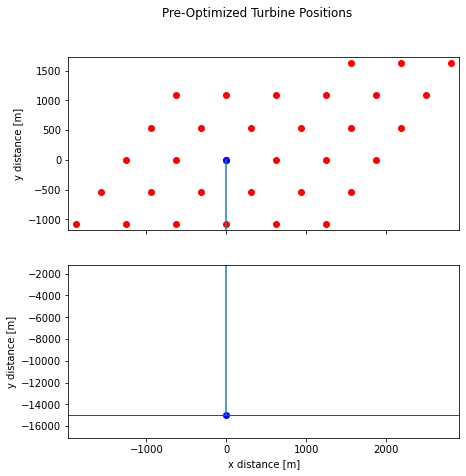

In [9]:
# Display pre-optimized turbine positions before clustering and MST

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)    
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

In [10]:
#Function to determine land cost of wind farm using a convex hull
#Calcualtes area of wind farm, onshore substation, and export cable
#Won't work for just 1 turbine since no boundary to enclose

def LandAreaCost(positionlist,ExportDistance):
    
    radius = 130 #m
    OnshoreSubLand = np.pi*radius**2 #Land area associated with the onshore substation
    ExportLand = ExportDistance*8 # Length*width 
    
    hull = ConvexHull(positionlist) #computes convex hull using the turbine positions
    LandArea = hull.volume + OnshoreSubLand + ExportLand #Calcualtes convex hull area and adds on the onshore substation land area

    LandCost = LandArea*LandCostpermSquared
    
    return LandCost

LandCost = LandAreaCost(positionlist,ExportDistance)

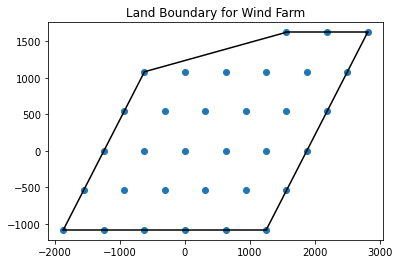

In [11]:
#Visual aid for convex hull plotting

hull = ConvexHull(positionlist)
plt.plot(positionlist[:,0], positionlist[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(positionlist[simplex, 0], positionlist[simplex, 1], 'k-')


plt.title('Land Boundary for Wind Farm')
plt.show()

C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Function run time: 0.1541037000000003
[[   0    3    4   14   15   16   17 -100 -100 -100 -100]
 [   0    1    8    9   10   24   25   26 -100 -100 -100]
 [   0    2   11   12   13   27   28   29   30   31   32]
 [   0    5    6    7   18   19   20   21   22   23 -100]]


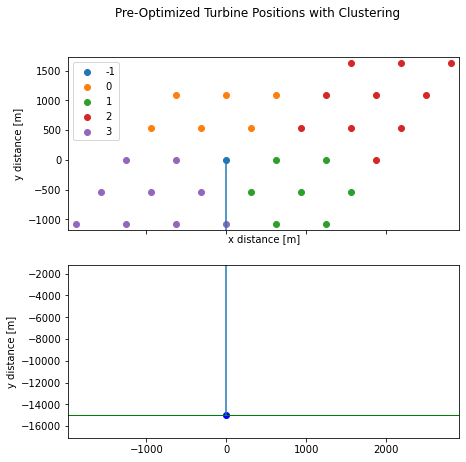

In [12]:
#CLUSTERING ALGORITHM

#Uses an adapted version of kmeans with a cap on the number of points per cluster. Used to radially cluster turbines
#into segments which MST algorithm can then use to determine cabling for a given radial array. Initially unnecessary
#for the initially structured turbine layout as seen above, but increasingly important as turbine layout becomes
#non-uniform through optimisation when the below function is repeatedly called.
# minsize_kmeans imported from external python file

def clustering_algorithm(positionlist,nturb,maxnodespertree):
    k = math.ceil(nturb/maxnodespertree) #number of clusters. math.ceil rounds a number upwards to its nearest integer
    [turbines, centres] = minsize_kmeans(positionlist[1:,:] ,k ,min_size = 1, max_size = maxnodespertree) 
    #turbines exists as an array containing the cluster value for each turbine
    #Assigns each turbine to a cluster. excludes substation, executes external python file, 
    #limits for how many turbines are in each cluster between 1 and max nodes per tree 
    label = np.concatenate((np.array([-1]),turbines)) # Adds -1 (substation label) to the other turbine labels
    u_labels = np.unique(label) 
    # finds unique elements of label. Finds the unique cluster labels 
    # each turbine is assigned a cluster/label and this returns a single label for each cluster
    
    a = 0
    indiceslist = np.empty((k,maxnodespertree), dtype=np.int8) # empty array of no.clusters by max nodes per tree
# indiceslist basically tells us what turbines belong to each cluster
# each row of indiceslist represents a cluster and each point on that row a indidual turbine within that cluster
# Each row starts with a 0 which represents the subsation which belongs to all clusters
# As seen before in the initial layout numbers are assigned starting at 1 which is the turbine (a,0) from the substation
# The numbering then continues in a cyclic motion traveling anticlockwise up until the total number of turbines
    
    for i in range(k): # loops for number of clusters
        indices = [i for i, x in enumerate(label) if x == a] # enumerate exists as a counter in the loop (starts at x=a=0)

        if len(indices) < maxnodespertree:
            noofemptys = maxnodespertree - len(indices)
            for l in range(noofemptys): # For the empty spaces in the matrix replaces these with -100 as fillers
                indices.append(int(-100))
    
        indiceslist[i,:] = (indices)
        a += 1
    
    arr = np.zeros((k,1),dtype=np.int8)   # zero array of number of clusters by 1 (Substation array)
    indiceslist = np.concatenate((arr,indiceslist),axis=1) # Adds substation zero array to turbine cluster matrix
    return indiceslist,u_labels,label

t1_start = perf_counter() # Starts timer
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) #Executes clustering algorithm
t1_stop = perf_counter() # Ends timer
print('Function run time:', t1_stop-t1_start) # Prints algorithm run time

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustering')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
for i in u_labels: # loops for number of turbines
    ax1.scatter(positionlist[label == i , 0] , positionlist[label == i, 1] , label = i)
ax1.legend() # prints legend
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_xlabel('x distance [m]') # x axis label
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

print(indiceslist)

In [13]:
#CREATES INPUT NEEDED FOR MST ONCE CLUSTERS ARE DEFINED.

#distance_global - distances of each turbine with respect to the substation and each other h=sqrt(x^2+y^2)
#e.g. row 0 would be each turbines distance with respect to the substation
# and row 4 would be each turbines distance with respect to the 4th turbine as found in the position list
# distance_globl[i,i] = 1e10 since this is the distance of each turbine with respect to itself so we want the MST to ignore thse values
#angle_global - angle of each turbine with respect to the substation and each other arctan(y/x)
#distance and angle then do something similar but considering the cluster formations as well

def geom_analysis(positionlist,indiceslist):
    
    #Arrays for pairwise distances and angles
    #Angle 0: x directıon. Angle pi/2: y directıon
    distance = [None] * math.ceil(nturb/maxnodespertree) # null array with size based on number of clusters
    angle = [None] * math.ceil(nturb/maxnodespertree) 
    distance_global = np.zeros((nturb,nturb)) #zero array nturb by nturb. This will be for storing the distance between each pair of turbines for cabling
    angle_global = np.zeros((nturb,nturb)) # Like above this will be for storing the angle data between each pair of turbines for cabling
    coords = positionlist[1:,:] # Coordinates of each turbine

    for i in range(0,nturb): # loops for number of turbines
        distance_global[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1])) # Pythagoras for hypotenuse
        angle_global[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0]) #Pythagoras for angle
        distance_global[i,i]=1e10
        #Rotate angles so that north=0 and convert to degrees
    angle_global=-np.rad2deg(angle_global)+270
    
    for x in range(0,math.ceil(nturb/maxnodespertree)): # loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1) # Everything except the -100 ones which were denoted earlier to show that there is no turbine at that index
        distance[x]=np.zeros((nturbintree,nturbintree))
        angle[x]=np.zeros((nturbintree,nturbintree))
    
        for i in range(0,nturbintree):
            for j in range(0,nturbintree):
                distance[x][i,j] = np.sqrt(np.square(positionlist[(indiceslist[x,i]),0]-positionlist[(indiceslist[x,j]),0]) + np.square(positionlist[(indiceslist[x,i]),1]-positionlist[(indiceslist[x,j]),1]))
                angle[x][i,j]=np.arctan2(positionlist[(indiceslist[x,j]),1]-positionlist[(indiceslist[x,i]),1],positionlist[(indiceslist[x,j]),0]-positionlist[(indiceslist[x,i]),0])
                distance[x][i,i]=1e10
        
        #Rotate angles so that north=0 and convert to degrees
        angle[x]=-np.rad2deg(angle[x])+270
      
    return distance,angle,distance_global,angle_global

In [14]:
# DETERMINES MINIMUM LENGTH OF CABLING REQUIRED TO CREATE COMPLETE CABLING NETWORK SUCH THAT ALL TURINES ARE CONNECTED
# IN ACCORDANCE WITH USER'S CONDITIONS.

def Minimum_Spanning_Tree(distance,indiceslist):

    MSTweight = [None] * math.ceil(nturb/maxnodespertree) # null array with sized based on number of clusters
   
    for x in range(0,math.ceil(nturb/maxnodespertree)): #loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        g=Graph(nturbintree) #Graph is part of the external python script titled Boruvka_Mod
        
        for i in range(0,nturbintree):
            for j in range(i+1,nturbintree):
                g.addEdge(i,j ,(distance[x][i,j]*1000))
           
        MSTweight[x]=g.boruvkaMST()
    return MSTweight

Each tree weight tree 1 3750000.0
Each tree weight tree 2 4375000.0
Each tree weight tree 3 6707531.754730549
Each tree weight tree 4 5625000.0
MST total weight 20457531.75473055 m


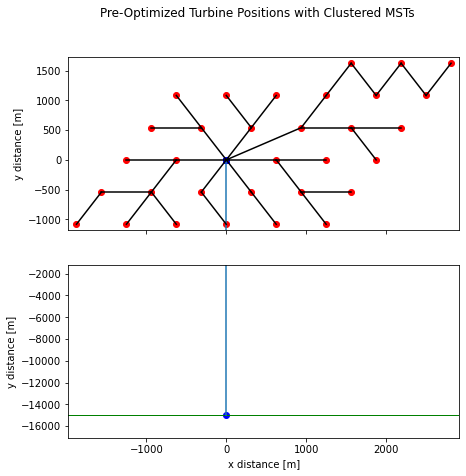

In [15]:
#PLOTTING PRE-OPTIMISED MST

# the Boruvka_mod code requires graphs with vertices 0....n, which is provided by the index value on indices list.
# When this is plotted, the values within the correct indiceslist row are then used to reference the index within
# positionlist to be plotted.

#

MSTweight=Minimum_Spanning_Tree(geom_analysis(positionlist, indiceslist)[0],indiceslist)

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustered MSTs')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

links = [None] * math.ceil(nturb/maxnodespertree)
MSTWeightSum = 0 #MST weight is simply the total length of cabling used

for a in range(0,math.ceil(nturb/maxnodespertree)):
    MSTWeightSum += MSTweight[a][0]
    print('Each tree weight', 'tree',a+1 ,MSTweight[a][0])
    links[a] = MSTweight[a][1]
    
    for b in links[a]:
        u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
        v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
        ax1.plot(u,v, c='black')
        ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue')
        
print('MST total weight', MSTWeightSum, 'm')

In [16]:
#DISPLAYS RAW BATHYMETRY DATA

print(data) # Prints out bathymetry data - Read in using pandas in previous section

      SURVEY_ID  TIMEZONE      DATE     TIME       LAT      LON  POS_TYPE  \
0        NSEA86         0  19860424  149.733  54.50260  4.42565       NaN   
1        NSEA86         0  19860424  150.700  54.50254  4.42011       NaN   
2        NSEA86         0  19860424  151.717  54.50247  4.41424       NaN   
3        NSEA86         0  19860424  152.683  54.50240  4.40861       NaN   
4        NSEA86         0  19860424  153.667  54.50234  4.40282       NaN   
...         ...       ...       ...      ...       ...      ...       ...   
18132    NSEA86         0  19860513  555.800  52.81589  4.07220       NaN   
18133    NSEA86         0  19860513  556.900  52.81516  4.07883       NaN   
18134    NSEA86         0  19860513  557.733  52.81459  4.08396       NaN   
18135    NSEA86         0  19860513  558.700  52.81396  4.08972       NaN   
18136    NSEA86         0  19860513  559.750  52.81325  4.09609       NaN   

       NAV_QUALCO  BAT_TTIME  CORR_DEPTH  ...  MAG_RESSEN  MAG_DICORR  \
0 

In [17]:
#CONVERTS LATITUDE AND LONGITUDE IN BATHYMETRY DATA TO CENTERED EASTINGS AND NORTHINGS

data['easting'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[0], axis=1) #Converts lon/lat to easting and adds this onto the 'data' file
data['northing'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[1], axis=1) #Converts lon/lat to northing and adds this onto the 'data' file

zero_east = min(data['easting']) + (max(data['easting']) - min(data['easting']))/2 +30000 # Determines centre of bathymrtry data in easting direction (+30,000 is simply to get a more interesting result from the current bathymetry data)
zero_north = min(data['northing']) + (max(data['northing']) - min(data['northing']))/2 # Determines centre of bathymetry data in northing direction   

data['centered_easting'] = data['easting'] - zero_east # Centres the data about (0,0) and adds this onto the 'data' file
data['centered_northing'] = data['northing'] - zero_north # Centres the data about (0,0) and adds this onto the 'data' file

print(data) 

      SURVEY_ID  TIMEZONE      DATE     TIME       LAT      LON  POS_TYPE  \
0        NSEA86         0  19860424  149.733  54.50260  4.42565       NaN   
1        NSEA86         0  19860424  150.700  54.50254  4.42011       NaN   
2        NSEA86         0  19860424  151.717  54.50247  4.41424       NaN   
3        NSEA86         0  19860424  152.683  54.50240  4.40861       NaN   
4        NSEA86         0  19860424  153.667  54.50234  4.40282       NaN   
...         ...       ...       ...      ...       ...      ...       ...   
18132    NSEA86         0  19860513  555.800  52.81589  4.07220       NaN   
18133    NSEA86         0  19860513  556.900  52.81516  4.07883       NaN   
18134    NSEA86         0  19860513  557.733  52.81459  4.08396       NaN   
18135    NSEA86         0  19860513  558.700  52.81396  4.08972       NaN   
18136    NSEA86         0  19860513  559.750  52.81325  4.09609       NaN   

       NAV_QUALCO  BAT_TTIME  CORR_DEPTH  ...   GRA_OBS  EOTVOS  FREEAIR  \

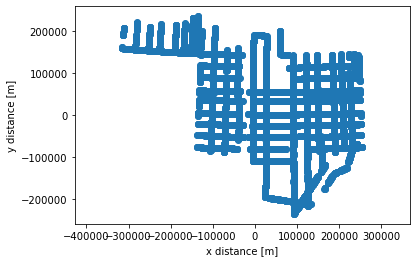

In [18]:
#PLOTS CENTERED BATHYMETRY DATA

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

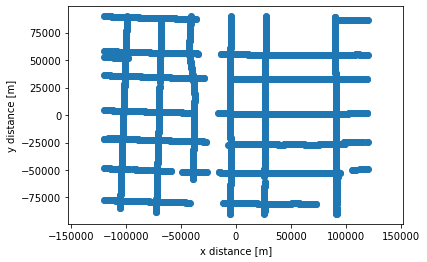

In [19]:
# SAMPLING AND PLOTTING CENTRAL BATHYMETRY DATA
# Takes sample between +/-120000 in easting direction, +/-90000 in the northing direction, and +/-1000 for the depth values

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data = data[(data['centered_easting'] >=-120000) & (data['centered_easting'] <= 120000) & (data['centered_northing']>=-90000) & (data['centered_northing']<= 90000) & (data['CORR_DEPTH']<=1000) & (data['CORR_DEPTH']>=-1000)]
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

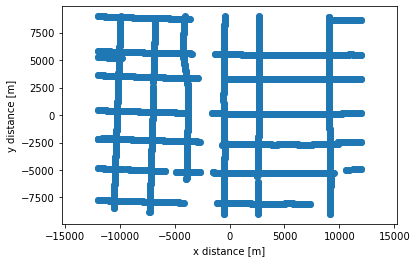

In [20]:
#FURTHER BATHYMETRY DATA PROCESSING
#Further decreases the area considered to be more applicable to the size of the wind farm (Sample from before divided by 10 in northing and easting directions)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data['centered_easting'] = data['centered_easting']/10
data['centered_northing'] = data['centered_northing']/10
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

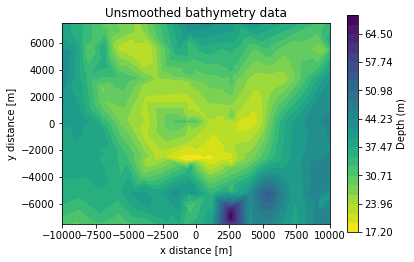

In [21]:
#UNSMOOTHED BATHYMETRY DATA CONTOUR PLOTTING

fig, ax = plt.subplots()
plt.xlim([-10000, 10000]) # x Limits of plot between +/-10000
plt.ylim([-7500, 7500]) # y Limits of plot between +/-7500
ax.set_aspect(aspect=1) # Sets the aspect of the axis scaling, i.e. the ratio of y-unit to x-unit.
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')

maxdepth = max(data['CORR_DEPTH'])
levels = np.linspace(mindepth,maxdepth,24) # Creates 24 even spaces or levels between the min and max depth

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], levels=levels, cmap = 'viridis_r') # (x,y,colour bar factor,level values,colour scale)
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Unsmoothed bathymetry data');

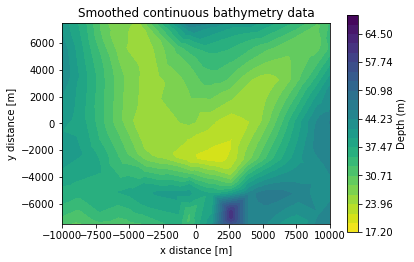

In [22]:
#SMOOTHING BATHYMETRY DATA

smooth = spline.SmoothBivariateSpline(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], s = 25000)

fig, ax = plt.subplots()
plt.xlim([-10000, 10000])
plt.ylim([-7500, 7500])
ax.set_aspect(aspect=1)
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
levels = np.linspace(mindepth,maxdepth,24)

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Smoothed continuous bathymetry data');

In [23]:
# DETERMINING DEPTH AND ASSOCIATED COST FOR EACH TURBINE

def depthvalues(positionlist):
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    DepthCostPerTurbine = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    DepthCostAllTurbines = np.float64(0) # Assigns initial value to variable

    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1]) # Acquires depth assigned to each turbines position (x,y)
        DepthCostPerTurbine[i] = MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(DepthPerTurbine[i])**2) - 0.0002*(float(DepthPerTurbine[i])) + 0.9459)-CostperTurbine #Formula for depth cost
        DepthCostAllTurbines += DepthCostPerTurbine[i] # Sums up all turbines depth costs
        
    mindepth=float(min(DepthPerTurbine))
    maxdepth=float(max(DepthPerTurbine))
    return DepthCostAllTurbines, mindepth, maxdepth # returns respective values to user

depthvalues(positionlist)

(4775749.0838871095, 21.417730125645445, 27.569994012441263)

In [24]:
#SETTING MODEL PARAMETERS

v0=8.0  #Incoming wind speed
nwind = 33
wind=np.arange(254,287)

#b=np.array((1,5,1000))
#b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))

# 3 model parameters below:

# 0th: how much power the turbine removes at the centre of the peak of the power distribution.
# 1st: how wide the angle of effect is. UNITS: degrees
# 2nd: up to how far back the effect takes place (approx. 2.6km) UNITS: [m]

model=np.array((1.39998719e-01, 8.51483871e+00, 2.62613638e+03))

ws=2.0 #weibull scale factor
wei_gamma=gamma(1.+1./ws)

Pr = 2*10**6 #Rated Power for Horns Rev 1 Turbines. Max power output [Watts]
Vc = 4.0 #Cut-in Velocity. Starts producing energy at wind speed of 4m/s [m/s]
Vr = 15.0 #Rated Velocity. Starts producing max energy at 15m/s
Vf = 25.0 #Cut-off Velocity. Turbines cut out at wind speeds of 25m/s to prevent damage to the turbines.
k = 2.0 #Weibull shape parameter
(Pr,Vc,Vr,k)

#interpolation parameters
dvel=1.5 #[m/s]
dang=5. #[degrees]

In [25]:
#DETERMINING WIND DIRECTION AND VELOCITY AT HORNS REV 1

v=np.loadtxt('hornsrev_data_all.txt') # assigns data to variable v.
vxref=v[:,3] # (INDEXING STARTS FROM 0). Third column of data is velocity of wind in x direction.
vyref=v[:,4] # (INDEXING STARTS FROM 0). Fourth column of data is velocity of wind in y direction.
angles=v[:,0] # Zeroth column of data is wind angle.
vmean=np.sqrt(np.square(vxref)+np.square(vyref)) # Uses pythagoras to find the wind magnitude + direction for each location.

vmean=pd.DataFrame(vmean) # organises vmean into labelled data structure
vref=pd.DataFrame()

vmean['angle']=angles # add another column to vmean (angle)
vref=vref.append(vmean) # add empty pandas data frame

vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0] # data manipulation to group by angle etc.

6.512913707119303

In [26]:
#Arrays for pairwise distances and angles
#Angle 0: x direction. Angle pi/2: y directıon

# calculates distance and angle between each pair of turbines:

distance=np.zeros((nturb,nturb)) # 2x2 matrix of distances between turbines i and j where distance i-i and distance j-j = 0
# as they're distances to themselves: i-i i-j
                                 #    j-i j-j

angle=np.zeros((nturb,nturb)) # same as above but for angles between turbines.

for i in range(0,nturb):
   
    # 80x80 matrices as there's 80 turbines at Horns Rev 1.
    # squares y distance and x distance then sqrt to find overall distance between 2 turbines.
    distance[i,:]=np.sqrt(np.square(positionlist[i+1,0]-positionlist[1:,0])+np.square(positionlist[i+1,1]-positionlist[1:,1]))
    # same as above using arctan2 whilst giving correct quadrant (between 2 turbines).
    angle[i,:]=np.arctan2(positionlist[1:,1]-positionlist[i+1,1],positionlist[1:,0]-positionlist[i+1,0])
# Rotate angles so that north=0 and convert to degrees (and clockwise instead of anticlockwise)
angle=-np.rad2deg(angle)+270

# Rotating angles to wind direction
windangle=5 # degrees
rotangles=np.mod(angle-windangle+180,360)-180

In [27]:
# IMPORTING WIND DIRECTION DATA

#meteorological data where north = 0 degrees)
directiondata = pd.read_csv ('Directiondata.csv')
print (directiondata)
# velocity is the mean velocity with which wind from this direction blows
# c determines how wide the distribution is
# frequency/100 determines how often the wind is blowing at this angle

    Angle  Velocity     c  frequency
0       0      8.89  2.09       4.82
1      30      9.27  2.13       4.06
2      60      8.23  2.29       3.59
3      90      9.78  2.30       5.27
4     120     11.64  2.67       9.12
5     150     11.03  2.45       6.97
6     180     11.50  2.51       9.17
7     210     11.92  2.40      11.84
8     240     11.49  2.35      12.41
9     270     11.08  2.27      11.34
10    300     11.34  2.24      11.70
11    330     10.79  2.19       9.69
12    360      8.89  2.09       4.82


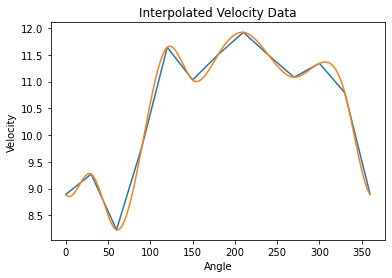

In [28]:
# interpolate 'velocity'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['Velocity']
wbvel = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360,0.10)
plt.plot(x,y, label='Line')
plt.plot(xs, wbvel(xs), label="Interpolated line ")
plt.title('Interpolated Velocity Data')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()
# blue lines shows linear interpolation, orange shows smooth interpolation including across the
# periodic boundary.

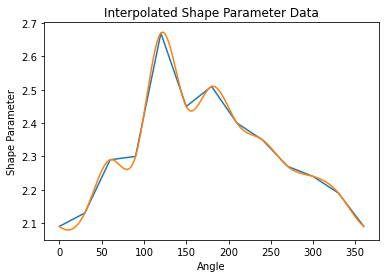

In [29]:
#interpolate 'c'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['c']
wbshape = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, wbshape(xs), label="S")
plt.title('Interpolated Shape Parameter Data')
plt.xlabel('Angle')
plt.ylabel('Shape Parameter')
plt.show()

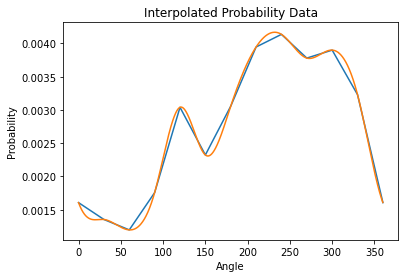

In [30]:
#interpolate 'frequency'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['frequency']/(100.*30.) #Data is in percent per 30 degrees, changing to probability per degree


windfreq = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, windfreq(xs), label="S")
plt.title('Interpolated Probability Data')
plt.xlabel('Angle')
plt.ylabel('Probability')
plt.show()
# plot shows wind direction is predominantly 200-320deg.

In [31]:
# Simple Attenuation fn
# Determines how much wind there is AFTER a turbine.
def att(dist, ang, model): 
        # 'Model' parameters are defined in 2ND CELL.

    # angular part
    angular=np.where(2.*model[1]*np.abs(ang)<np.pi,np.square(np.cos(model[1]*ang)),0.)
    # angular = np.cos(model[1]*ang WHEN 2.*model[1]*np.abs(ang) is less than pi, else angular = 0.
    
    # radial part (distance) (Gaussian Function)
    radial=np.exp(-np.square(dist/model[2])) # decreasing exponential of square, scaled by 2nd parameter
    penalty=np.exp(-np.square(dist/200))
    #penalty = 0
    return 1.0-1*model[0]*angular*radial-2*model[0]*penalty # OUTCOME

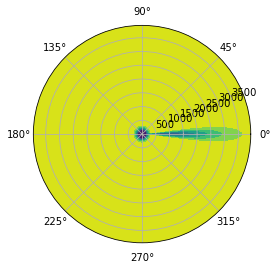

0.580003843


In [32]:
azimuths = np.radians(np.linspace(0, 360, 360)) # angles theta from 0 to 360 degress in 1 degree increments. Grid
zeniths = np.arange(0, 4000, 50) # distance from 0 to 4000 broken up into increments of 50.

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,np.mod(theta+np.pi,np.pi*2)-np.pi,model) # gets angles from -pi to pi, not from 0 to 2pi.

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, np.maximum(values,0.85*np.ones(np.shape(values))))

plt.show()
print(np.min(values))

## Cell description:
# Polar plot is for 1 turbine, blue area shows where wind speed is affected. (Numbers label distance from turbine).
# Across the curve the distribution is the hump of cosine^2 function.
# Radially the distribution shown is Gaussian.
# Wake is currently too narrow close to the turbine as it treats the turbine as a point rather than accommodating
# for the blades' diameter.

In [33]:
# # isn't useful for continuing code, just rotates the windfarm.
# def rotate(angle,coords):
#     angle = np.pi*angle/180.
#     rotcoordx = []
#     rotcoordy = []
#     for coord in coords:
#         rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
#         rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
#     rotcoords=[rotcoordx,rotcoordy]
#     rotcoords=np.array(rotcoords).T   
#     return rotcoords 
# #print rotate(254,coords)[:,0]
# plt.scatter(rotate(0,coords)[:,0],rotate(0,coords)[:,1])

In [34]:
# returning total deviation between model and training set (between CFD data and the attenuation model)
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [35]:
# returning deviation for each turbine.
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation_sq(model):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,model)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

In [36]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the % of wind that arrives at a turbine for a certain angle.
# Starts with assumption that there's zero wake so all turbines get full wind.
#talked about
#Total att
def windspeedreduction(distance,angle,direction,model): # vectors
    ndir=np.size(direction)
    total_att=np.ones((nturb,ndir)) # as many rows as there are turbines, as many columns as there are wind directions.
 #   power_vec=np.zeros((nturb,ndir))
    for j in range(0,nturb):
        for i in range(0,nturb):
            if (i!=j):
                # compounding wind speed reductions
                total_att[j,:] = total_att[j,:]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-direction[:])+np.pi,np.pi*2)-np.pi,model)
  #      power_vec[j,:]=(v0*total_att[j,:])**3
    return total_att # matrix output that's needed. n turbine rows, n direction columns.
                     # Tells how much of 100% of wind arrives at a certain turbine from a certain direction.

In [37]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the power produced by turbines when it sees a certain wind speed at a certain angle. 3D matrix
def power(wsr,v): # wind speed reduction, velocity
    nvel=np.size(v)
    nangle=np.size(wsr,1)
    power_vec=np.zeros((nturb,nangle,nvel))
    power_vec=POvec(np.outer(wsr,v)).reshape(nturb,nangle,nvel) # np.outer takes every wsr element and individually multiplies it with every element of v.
    return power_vec

In [38]:
#GIVES PROBABILITY OF WIND SPEED V AT A GIVEN ANGLE
def windspeedprobability(angles,v,d_angle,d_vel):
    nvel=np.size(v) 
    nangle=np.size(angles)
    wsprob=np.zeros((nangle,nvel))
    for i in range(angles.shape[0]):
        # Get Weibull parameters for angle and evaluate probability
        wsprob[i,:]=(wei(v[:],wbvel(angles[i]),wbshape(angles[i])))*windfreq(angles[i])*d_angle*d_vel
    return wsprob

In [39]:
# DEFINES WEIBULL DISTRIBUTION (shows the probability of any given wind speed occuring).

def wei(x,n,k): # convention to have in this order, scale parameter comes first (x) 
    u=n/gamma(1+1/k) #scaled wind speed
    return (k / u) * (x / u)**(k - 1) * np.exp(-(x / u)**k)
# k = Weibull shape parameter
# n = scale parameter
# x= value we are valuating

In [40]:
def wind_dist(v,vm):
    return wei(v,vm,k)

In [41]:
wind_dist(1.0,v0)

0.024244336764100854

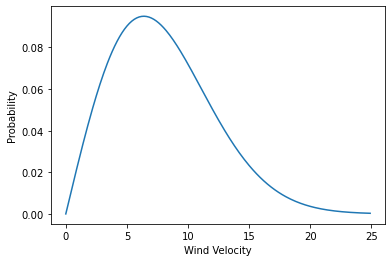

In [42]:
# PLOTS WEIBULL DISTRIBUTION

x=np.arange(0,25,0.1)
y=wind_dist(x,v0)

plt.xlabel('Wind Velocity')
plt.ylabel('Probability')
plt.plot(x,y)

In [43]:
velocities=np.arange(Vc,Vf,dvel) # 1D array ranging from Vc to Vf in dvel intervals. 4 to 25 in steps of 1.5
angles=np.arange(0,360,dang) # 0 to 360 with intervals of dang.
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.
# sum of all numbers would add up to 1.
print(wsp,np.shape(wsp),np.sum(wsp)) # wsp array, shape of wsp (rows,columns), sum of wsp elements
print(np.shape(velocities)) # shape of velocities array (rows, columns)
#plt.plot(x,y)

[[7.95303494e-04 9.80036676e-04 1.05789271e-03 ... 6.39190809e-05
  3.40253887e-05 1.70630457e-05]
 [7.34767202e-04 9.01764403e-04 9.69915308e-04 ... 5.75583274e-05
  3.06371248e-05 1.53701909e-05]
 [6.87320078e-04 8.44491359e-04 9.10294073e-04 ... 5.77144043e-05
  3.11157981e-05 1.58295009e-05]
 ...
 [9.80182139e-04 1.25683306e-03 1.41621103e-03 ... 1.55577912e-04
  9.05953796e-05 4.99151675e-05]
 [9.27369324e-04 1.17045619e-03 1.29626789e-03 ... 1.10756647e-04
  6.20462178e-05 3.28196113e-05]
 [8.63068120e-04 1.07416013e-03 1.17166708e-03 ... 8.08008629e-05
  4.38237311e-05 2.24068824e-05]] (72, 14) 0.9458659589195532
(14,)


In [44]:
# CALCULATES THE POWER CURVE OF A TURBINE

# Plots the power curve of a turbine.
# No power output from 0-4m/s, then cubic rise up to 15m/s and stays
# constant until cut-off velocity of 25m/s.

#cubic Based Power output
a=Pr/(Vr**3-Vc**3)
b=Vc**3/(Vr**3-Vc**3)

def q(v): # q is power output

    if (v<Vc): # below cut in velocity power is 0.
        q=0
    elif (v<Vr):
        q=a*v**3-b*Pr # cubic power output between cut in and max.
    elif (v<Vf):
        q=Pr # max power between max and cut off velocity.
    else: 
        q=0 # no power above cut off velocity.
    return q

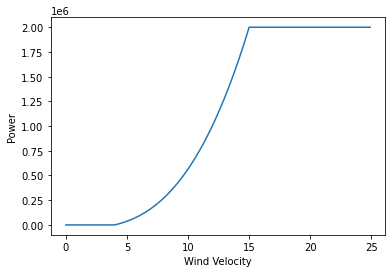

In [45]:
#PLOTS TURBINE POWER CURVE

x=np.arange(0,25,0.1)
POvec=np.vectorize(q) # vectorises power output function q (from cell above).
y=POvec(x)

plt.xlabel('Wind Velocity')
plt.ylabel('Power')
plt.plot(x,y)

In [46]:
wsr=windspeedreduction(distance,angle,angles,model)
print(wsr)
powout=power(wsr,velocities)
wsr

[[0.88180781 0.93586905 0.9990748  ... 0.99991966 0.9990748  0.93586905]
 [0.99990359 0.99990359 0.99990359 ... 0.99990359 0.99990359 0.99990359]
 [0.99991966 0.99991966 0.99991966 ... 0.99991966 0.99991966 0.99991966]
 ...
 [0.99996786 0.99996786 0.99996786 ... 0.99996786 0.99996786 0.99996786]
 [0.99993572 0.99993572 0.99993572 ... 0.99993572 0.99993572 0.99993572]
 [0.99995179 0.99995179 0.99995179 ... 0.99995179 0.99995179 0.99995179]]


array([[0.88180781, 0.93586905, 0.9990748 , ..., 0.99991966, 0.9990748 ,
        0.93586905],
       [0.99990359, 0.99990359, 0.99990359, ..., 0.99990359, 0.99990359,
        0.99990359],
       [0.99991966, 0.99991966, 0.99991966, ..., 0.99991966, 0.99991966,
        0.99991966],
       ...,
       [0.99996786, 0.99996786, 0.99996786, ..., 0.99996786, 0.99996786,
        0.99996786],
       [0.99993572, 0.99993572, 0.99993572, ..., 0.99993572, 0.99993572,
        0.99993572],
       [0.99995179, 0.99995179, 0.99995179, ..., 0.99995179, 0.99995179,
        0.99995179]])

In [47]:
# EXPECTED TURBINE OUTPUT (Watts) for the given wind distribution and positions.
# Can be seen that top left (NW) produces most energy for Horns Rev 1 Wind Farm.

# EXPECTED POWER FROM WIND FARM CALCULATIONS
# multiply the power that you'd get for each wind angle and speed condition by the probability of this occuring, for all angles and speed
# values and sum to find the expected power.
# Sum up this value for all turbines to find total wind farm expected power output.
output=np.zeros((nturb)) 
output=np.tensordot(powout,wsp,2)
print(output,np.shape(output),np.sum(output))
# last output is total power output in Watts.

[732160.5567469  724454.6320561  730510.74323713 744175.23458048
 760869.2406594  787416.85463932 764638.06520513 752547.50074185
 747686.24655662 729892.69274592 727863.7711711  735549.39076199
 730007.78020999 729589.63545079 740039.4773415  759457.37368276
 772403.61308659 787038.30921061 811572.97633553 838284.53607227
 819898.1454696  799004.29967104 781550.86162463 772496.051005
 769637.148119   747674.56938132 735536.3855687  737674.59915734
 748679.50595381 767520.61530825 751171.95186684 743049.0925235 ] (32,) 24280051.856141012


In [48]:
# TURBINE OUTPUT (Watts) WITH NO INTERFERENCE

#Reference output:
# Same calculations as cell above except each turbine sees the full amount of wind every time
# (i.e. no wind reduction from other turbines).
refpowout=power(np.ones((nturb,np.size(angles))),velocities)
refoutput=np.zeros((nturb))
refoutput=np.tensordot(refpowout,wsp,axes=2)
print(refoutput,np.shape(refoutput),np.sum(refoutput))

# last output is total power output in Watts.

[867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078] (32,) 27749141.12258502


In [49]:
# # assigns smaller interpolation intervals to dvel and dang to compare to coarser interpolations.
# dvel=0.1
# dang=0.1
# velocities=np.arange(Vc,Vf+dvel,dvel)
# angles=np.arange(0,360,dang)
# wsp=windspeedprobability(angles,velocities,dang,dvel)
# wsr=windspeedreduction(distance,angle,angles,model)
# powout=power(wsr,velocities)
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print (dvel,dang,np.sum(output))
# fineout=output

In [50]:
# # Calculates RMS error from changing interpolation value.
# velarray=np.array([1.5])
# angarray=np.array([5])
# rmserror=np.zeros((np.size(velarray),np.size(angarray)))
# i=0
# for dvel in velarray:
#     j=0
#     for dang in angarray:
#         velocities=np.arange(Vc,Vf+dvel,dvel)
#         angles=np.arange(0,360,dang)
#         wsp=windspeedprobability(angles,velocities,dang,dvel)
#         wsr=windspeedreduction(distance,angle,angles,model)
#         powout=power(wsr,velocities)
#         output=np.zeros((nturb)) 
#         output=np.tensordot(powout,wsp,2)
#         rmserror[i,j]=np.sqrt(np.sum(np.square(output-fineout))/np.size(output))
#         print (dvel,dang,np.sum(output),rmserror[i,j])
#         j+=1
#     i+=1
# print(rmserror)

In [51]:
distance,angle,distance_global, angle_global = geom_analysis(positionlist,indiceslist)
wsr=windspeedreduction(distance_global,angle_global,angles,model)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)

In [52]:
def foundationDepthCost(foundation,DepthPerTurbine):
    
    FoundationCost = foundation*(0.0002*(float(DepthPerTurbine)**2) - 0.0002*(float(DepthPerTurbine)) + 0.9459)
    
    return FoundationCost

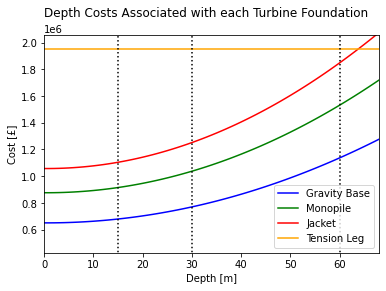

In [53]:
# Plots depth functions for each individual turbine foundation type

Depthx = range(0,math.ceil((max(data['CORR_DEPTH']))),1)
GBCost = [None] * len(Depthx)
MPCost = [None] * len(Depthx)
JCost = [None] * len(Depthx)
TLCost = [None] * len(Depthx)
Depth = 0

for i in Depthx:
    GBCost[i] = foundationDepthCost(GravityBase,Depth)
    MPCost[i] = foundationDepthCost(Monopile,Depth)
    JCost[i] = foundationDepthCost(Jacket,Depth)
    TLCost[i] = TensionLeg
    Depth += 1
    
fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with each Turbine Foundation')

x1 = np.linspace(15,15,100)
x2 = np.linspace(30,30,100)
x3 = np.linspace(60,60,100)
y = np.linspace(0,TensionLeg+500000,100)

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx,GBCost,'blue')
ax.plot(Depthx,MPCost,'green')
ax.plot(Depthx,JCost,'red')
ax.plot(Depthx,TLCost,'orange')
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

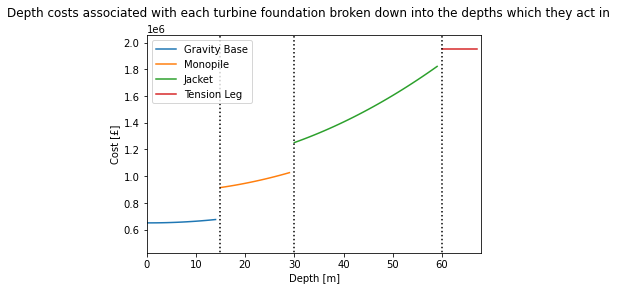

In [54]:
# Plots depth functions for each individual turbine foundation type but only considers the depths for which the foundation will act in

GBCost2 = GBCost[Depthx[0]:Depthx[15]]
MPCost2 = MPCost[Depthx[15]:Depthx[30]]
JCost2 = JCost[Depthx[30]:Depthx[60]]
TLCost2 = TLCost[Depthx[60]:max(Depthx)]

fig, ax = plt.subplots()
fig.suptitle('Depth costs associated with each turbine foundation broken down into the depths which they act in')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:15],GBCost2)
ax.plot(Depthx[15:30],MPCost2)
ax.plot(Depthx[30:60],JCost2)
ax.plot(Depthx[60:max(Depthx)],TLCost2)
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

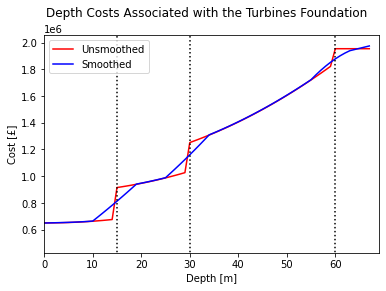

In [55]:
# Combines all the indivdual depths costs over there used depths into one plot and smooths the data

GBMPJTL = GBCost2+MPCost2+JCost2+TLCost2

fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with the Turbines Foundation')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH'])))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:max(Depthx)],GBMPJTL,color='r')
smoothed_2dg = savgol_filter(GBMPJTL, window_length = 9, polyorder = 1)
ax.plot(Depthx[0:max(Depthx)], smoothed_2dg, color='b')
plt.legend(['Unsmoothed','Smoothed'])
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')

In [56]:
def foundations(positionlist):
    
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    FoundationCost = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    FoundationCostTotal = 0 # Assigns initial value to variable
    
    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1])
        
        FoundationCost[i] = np.interp(DepthPerTurbine[i],Depthx[0:max(Depthx)],smoothed_2dg)

        FoundationCostTotal += FoundationCost[i]
        
    return FoundationCostTotal

FoundationCostTotal = foundations(positionlist)

In [57]:
# Function for calculated payback time, discounted payback time, Net Present Value, and Profitability Index

def Payback(TPO,TotalCost,positionlist):
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation at positonlist[0,:]
    
    CashFlowYearly = (ElectricityCostperkWh*24*365*(TPO/1000))-(OperatingandMaintenanceCostsperAnnum*nturb) # Calculates the yaerly cash flow for the windfarm
    PayBackTime = TotalCost/CashFlowYearly # calculates payback time in years
    DiscountedPayBackTime = (np.log(1/(1-((TotalCost*DiscountRate)/CashFlowYearly))))/np.log(1+DiscountRate) #Calculates payback time but takes into account the time value of money
    
    l=0
    NPV = 0
    
    for l in range(LifeTimeTurbineOperatingTime):
        l+=1
        NPV = NPV + (CashFlowYearly)/((1+DiscountRate)**l) #NPV is a method used to determine the current value of future cash flows generated by the project
    
    NPV = NPV - TotalCost
    ProfIndex = (NPV+TotalCost)/TotalCost # Probability index >1 it's profitable <1 its not
    
    return PayBackTime,DiscountedPayBackTime,NPV,ProfIndex

In [58]:
#PLOTTING FUNCTION

def plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance):
    
    mindepth = depthvalues(positionlist)[1]
    maxdepth = depthvalues(positionlist)[2]
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation ar positonlist[0,:]
    links = [None] * math.ceil(nturb/maxnodespertree) # math.ceil rounds a number upwards to its nearest integer
    MSTWeightSum = 0

    fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
    fig.suptitle('Plot Showing Sea Floor Topography and Turbines with Cables')
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    ax1.set_ylabel('y distance [m]') # y axis label
    ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    ax2.set_xlabel('x distance [m]') # x axis label
    ax2.set_ylabel('y distance [m]') # y axis label
    ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits
    
    for a in range(0,len(MSTweight)):
        MSTWeightSum += MSTweight[a][0]
        links[a] = MSTweight[a][1]
        for b in links[a]:
            u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
            v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
            ax1.plot(u,v, c='black')
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal =(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine 
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal 

    print('\033[1m'+'Maximum turbines per MST:'+'\033[0m', maximumturbinespertree)
    print('\033[1m'+'Number of turbines:'+'\033[0m', nturb)
    print()
    print('\033[1m'+'Inter-Array Cabling Costs: £'+'\033[0m', CableCost)
    print('\033[1m'+'Export Cabling Costs: £'+'\033[0m', ExportCableCost)
    print('\033[1m'+'Depth Cost: £'+'\033[0m', DepthCostAll)
    print('\033[1m'+'Foundations Cost: £'+'\033[0m', FoundationCostTotal)
    print('\033[1m'+'Turbine Cost: £'+'\033[0m', TurbineCostTotal)
    print('\033[1m'+'Land Cost: £'+'\033[0m', LandCost)
    print('\033[1m'+'Maintenance Cost: £'+'\033[0m', MaintenanceCosts)
    print('\033[1m'+'Fixed Cost:'+'\033[0m', FixedCost)
    print()
    print('\033[1m'+'Budget: £'+'\033[0m', budget)
    print('\033[1m'+'Total Cost: £'+'\033[0m', TotalCost)
        
    levels = np.linspace(mindepth-3,maxdepth+3,24) # Change to min(smooth) and max(smooth) somehow
    
    fig.subplots_adjust(left=0.1, right=0.8) #Adjusts plots to be able to fit a single color bar across both plots
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    tcf = ax1.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8]) #Locates colorbar across both subplots
    cbar = plt.colorbar(tcf,cax=cb_ax) #plots colorbar with location as stated by cb_ax
    cbar.set_label('Depth (m)')    
    
    ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
    ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
    ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    tcf = ax2.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')

    ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
    ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
    ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    fig, ax3 = plt.subplots()
    PieChartLabels = ['(Inter-Array) Cabling Costs', 'Depth Costs', 'Turbine Costs', 'Land Costs', '(Life time) Maintenance Costs', 'Fixed Costs','(Export) Cabling Costs','Foundation Costs'] # Titles for each segment of pie chart
    sizes = [CableCost,DepthCostAll,TurbineCostTotal,LandCost,MaintenanceCosts,FixedCost,ExportCableCost,FoundationCostTotal] # Figures for each segment of pie chart
    
    ax3.pie(sizes, labels=PieChartLabels, autopct='%1.1f%%') # Pie chart with brekadown of all associated costs
    ax3.axis('equal') #equal aspect ratio
    ax3.set_title('Wind Farm Costs') #Pie chart title
                                                                                                  
    return TotalCost

PRE-OPTIMISED LAYOUT INFORMATION

Maximum turbines per MST: 10
Number of turbines: 32

Inter-Array Cabling Costs: £ 7034640.331122471
Export Cabling Costs: £ 10507878.151260504
Depth Cost: £ 4775749.0838871095
Foundations Cost: £ 32213579.95805428
Turbine Cost: £ 71058475.20355292
Land Cost: £ 14008002.251898203
Maintenance Cost: £ 41920000.0
Fixed Cost: 10285714.285714285

Budget: £ 200000000.0
Total Cost: £ 191804039.26548976
Total Power Output: 24280051.856141012 W
Theoretical Max Total Power Output: 27749141.12258502 W
Percentage power lost to wake effcts: 12.501609513313971 %
Cost per Watt 7.899655256171863 £/W

Payback Time: 6.7224586921617115 years
Discounted Payback Time: 9.399512401077626 years
NPV: £ 110462559.5156067 over a  20 year period
Profitability Index: £ 1.5759136248570216 over a  20 year period


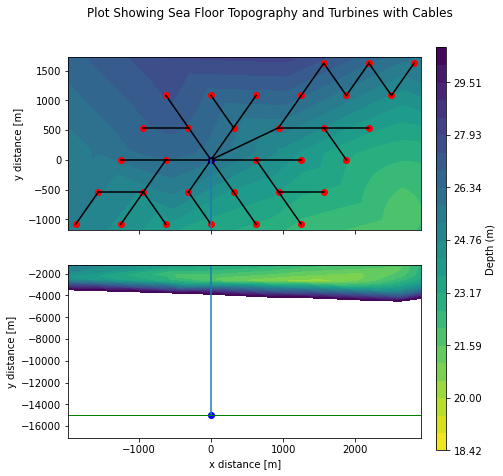

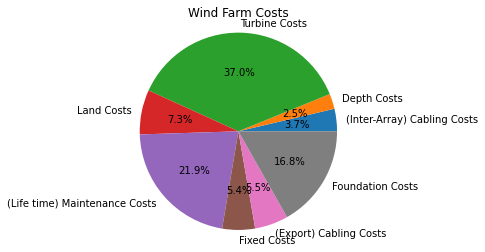

In [59]:
## Below calculates max theoreticl power output
wsr_noWake = np.ones(wsr.shape)
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power_pre = np.sum(output_noWake)

#DISPLAYING PRE-OPTIMISED LAYOUT AND ASSOCIATED INFO
print('\033[1m'+'\033[4m'+'PRE-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
print()
MSTweight = Minimum_Spanning_Tree(distance,indiceslist)
TotalCost = plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance)

PayBackTime,DiscountedPayBackTime,NPV,ProfIndex = Payback((np.sum(output)),TotalCost,positionlist)

# print('\033[1m'+'Total Power Output:'+'\033[0m', np.sum(output), 'W')
# print('\033[1m'+'Cost per Watt:'+'\033[0m',TotalCost/np.sum(output),'£/W')
# print('')
# print('\033[1m'+'Payback Time:'+'\033[0m',PayBackTime,'years')
# print('\033[1m'+'Discounted Payback Time:'+'\033[0m',DiscountedPayBackTime,'years')
# print('\033[1m'+'NPV: £'+'\033[0m',NPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
# print('\033[1m'+'Profitability Index: £'+'\033[0m',ProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

print('\033[1m'+'Total Power Output:'+'\033[0m', np.sum(output), 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power_pre, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(np.sum(output)/theoretical_max_power_pre))*100, '%')
print('\033[1m'+'Cost per Watt'+'\033[0m',TotalCost/np.sum(output),'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',PayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',DiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',NPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',ProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [60]:
#REDUCING NO. OF TURBINES PRE-OPTIMISATION
overspend = TotalCost - budget
if overspend > 0:
    nturbstoremove = math.floor(overspend/(MinCostperTurbTot))
    ### It can be safely assumed that this many turbines at minimum can be removed.
    print('Number of removed turbines:', nturbstoremove)
    for amount in range(0,nturbstoremove):
        nturb = nturb - 1
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)
    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    print('new number of turbines:', nturb)

In [61]:
v=2
for amount in range(0,v):
    nturb = nturb - 1
    positionlist = np.delete(positionlist, len(positionlist)-1, 0)
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)

C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [62]:
#TARGET FUNCTION

# analyses the coordinates to collate the distances and angles between all of them
# calculates the minimum spanning tree length and adds the assumption of cabling costs,
# turbines costs, maintenance costs and fixed costs.

smallestindiceslist = []
smallestTotalCost = None
smallestCostPerWatt = 10000000000000.0
smallestpositionlist = []
smallestExportDistance = None

def targetfunction(coord_flat):
    
    #Global variables are used instead of res.x as res.x only holds the coordinates, not the other associated parameters,
    #inc. the optimal clustering, which will not necessarily be the same if the clustering algorithm is run again as the
    #start position is random for clustering. Additionally, res.x only provides an approximate minimization, whereas
    #storing values as global variables and finding the minimum guarantees that the minimum value found is returned.
    
    global smallestindiceslist
    global smallestTotalCost
    global smallestCostPerWatt
    global smallestpositionlist
    global smallestExportDistance

    arr2=np.reshape(coord_flat,(-1,2)) # undoes the coordinate flattening
    hull = ConvexHull(arr2)
    arr1 = np.array([np.mean(hull.points[hull.vertices,0]),np.mean(hull.points[hull.vertices,1])])
    arr1 = np.reshape(arr1,(-1,2))
    positionlist = np.concatenate((arr1,arr2),axis=0)
    #positionlist = np.reshape(coord_flat,(-1,2))#np.concatenate((arr1,arr2),axis=0) #np.reshape(coord_flat,(-1,2))
    
    nturb=np.size(positionlist,0)-1 # determines number of turbines (-1 due to the substation)
    print('nturb', nturb)
    
    OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist)

    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) # calls clustering function
    distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist) # calls pre-MST function
    
    MSTweight=Minimum_Spanning_Tree(distance,indiceslist) # Calls MST function
    MSTWeightSum=0
    
    for a in range(0,math.ceil(nturb/maxnodespertree)): 
        MSTWeightSum += MSTweight[a][0] 
        
    wsr=windspeedreduction(distance_global,angle_global,angles,model) # calls wake attenuation function
    powout=power(wsr,velocities) # total output power
    output=np.tensordot(powout,wsp,axes=2) # reduced power output due to wake effects
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost= (MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal= (nturb)*CostperTurbine
    MaintenanceCosts= (nturb)*MaintenanceCostperTurbine
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost= TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal

    print('Total power output in Watts', np.sum(output),'Total Cost in £', TotalCost, '£/W', (TotalCost/(np.sum(output))))###

    CostperWatt = TotalCost/(np.sum(output))
    
    if CostperWatt < smallestCostPerWatt:
        smallestCostPerWatt = CostperWatt
        smallestindiceslist = indiceslist
        smallestTotalCost = TotalCost
        smallestpositionlist = positionlist
        smallestExportDistance = ExportDistance

    print('smallest cost per watt',smallestCostPerWatt)
    
    return CostperWatt

In [63]:
# OPTIMIZATION

#xright = 0
#xleft = 0
#yup = 0
#ydown = 0
#for xright in range(0,nturb+1):
 #   if positionlist[xright,0]>0:
  #      positionlist[xright,0] = positionlist[xright,0] + 250
#for xleft in range(0,nturb+1):
 #   if positionlist[xleft,0]<0:
  #      positionlist[xleft,0] = positionlist[xleft,0] - 250
#for yup in range(0,nturb+1):
 #   if positionlist[yup,1]>0:
  #      positionlist[yup,1] = positionlist[yup,1] + 250
#for ydown in range(0,nturb+1):
 #   if positionlist[ydown,1]<0:
  #      positionlist[ydown,1] = positionlist[ydown,1] - 250
        
        
t1_start = perf_counter() # timer starts

while True:  
    
    iteration_time_start = perf_counter()
    
    #flat_coords=positionlist.flatten() # turns 2D coords into single list of data without any more structure.
    flat_coords=positionlist[1:,:].flatten() # turns 2D coords into single list of data without any more structure.
    dvel=1.5
    dang=5
    velocities=np.arange(Vc,Vf,dvel)
    angles=np.arange(0,360,dang)        
            
    # b = (Lower bound, Upper bound)
    b2 = ((min(positionlist[:,0]))-1000,(max(positionlist[:,0]))+1000) #bounds for x coordinates
    #b3 = ((OnshoreSubstation[1]+((TooCloseShore-2500))),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    b3 = (((min(positionlist[:,1]))-1000),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    bnd = (b2,b3) #bounds for x,y coordinates of each turbine 
    bnd1 = (bnd*(nturb)) #repeats bnd for the amount of turbines 
    bnds = bnd1 #Combines all bounds into a list for use in the optimization function
    
    #res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, bounds=bnds, options={'disp': 2, 'eps': 50, 'ftol': 1e-17, 'gtol': 1e-17})
    res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, options={'disp': 2, 'eps': 50})#, 'ftol': 1e-17, 'gtol': 1e-17})

    #res = minimize(targetfunction, flat_coords, method='Nelder-Mead', jac=False, bounds=bnds, options={'disp': 2, 'xatol': 1e-3, 'fatol': 1e-3})#, 'ftol': 1e-17, 'gtol': 1e-17})
    #res = minimize(targetfunction, flat_coords, method='TNC', jac=False, bounds=bnds, options={'disp': 2, 'eps':50})#, 'ftol': 1e-17, 'gtol': 1e-17})
    
    iteration_time_end = perf_counter()
    print(iteration_time_end-iteration_time_start)
    
    if smallestTotalCost<=budget: #if under budget
        if not res.success:
            print(res.status, res.message) 
        else:
            break # Stops optimization when minimization is under budget after an iteration of 'minimize' 
    else: # over budget then removes a turbine and resets approrate varaibles 
        nturb = nturb - 1 
        smallestindiceslist = []
        smallestTotalCost = None
        smallestCostPerWatt = 10000000000000.0
        smallestpositionlist = []
        smallestExportDistance = None
        
        wsr=windspeedreduction(distance_global,angle_global,angles,model)
        powout=power(wsr,velocities) # total output power
        outputs=np.tensordot(powout,wsp,axes=2)
        LowestPower = min(outputs)
        LowestPowerIndex = np.argmin(outputs)
        LowestPowerTurbine = positionlist[LowestPowerIndex+1,:]
        positionlist = np.delete(positionlist, LowestPowerIndex+1, 0) 

        # CANNOT USE CALLBACK as this only returns targetfunction output and not the other variables that are needed too.
          
t1_stop = perf_counter() # timer ends
totaltime = t1_stop - t1_start # total run time in seconds
print('Total function time:', totaltime)

nturb 30
Total power output in Watts 22880028.728944004 Total Cost in £ 180482479.93026423 £/W 7.8882103719541155
smallest cost per watt 7.8882103719541155
nturb 30
Total power output in Watts 22878496.017503414 Total Cost in £ 180413445.22890812 £/W 7.885721381811159
smallest cost per watt 7.885721381811159
nturb 30
Total power output in Watts 22876909.285029516 Total Cost in £ 180494942.13921446 £/W 7.889830741136393
smallest cost per watt 7.885721381811159
nturb 30
Total power output in Watts 22879591.48608334 Total Cost in £ 180402588.78770405 £/W 7.884869312349178
smallest cost per watt 7.884869312349178
nturb 30
Total power output in Watts 22878708.196000915 Total Cost in £ 180413720.5524967 £/W 7.885660283216171
smallest cost per watt 7.884869312349178
nturb 30
Total power output in Watts 22878630.383934658 Total Cost in £ 180420588.27245948 £/W 7.885987283537329
smallest cost per watt 7.884869312349178
nturb 30
Total power output in Watts 22878666.791719157 Total Cost in £ 1804

Total power output in Watts 22877885.410580467 Total Cost in £ 180521104.59709358 £/W 7.890637677274445
smallest cost per watt 7.87956458433474
nturb 30
Total power output in Watts 22881475.798411723 Total Cost in £ 180612330.1003053 £/W 7.893386409666905
smallest cost per watt 7.87956458433474
nturb 30
Total power output in Watts 22879335.604896743 Total Cost in £ 180399964.8467548 £/W 7.884842810214504
smallest cost per watt 7.87956458433474
nturb 30
Total power output in Watts 22882162.053962026 Total Cost in £ 180713313.028406 £/W 7.897562852768786
smallest cost per watt 7.87956458433474
nturb 30
Total power output in Watts 22881160.864366774 Total Cost in £ 180471827.1137473 £/W 7.887354500216778
smallest cost per watt 7.87956458433474
nturb 30
Total power output in Watts 22881984.58992417 Total Cost in £ 180744736.0744303 £/W 7.898997369048978
smallest cost per watt 7.87956458433474
nturb 30
Total power output in Watts 22881238.70827737 Total Cost in £ 180853301.56853825 £/W 7.90

Total power output in Watts 22878798.348403282 Total Cost in £ 180281850.27250585 £/W 7.87986534638467
smallest cost per watt 7.8686765457549335
nturb 30
Total power output in Watts 22874486.556472998 Total Cost in £ 180314485.0139047 £/W 7.882777371581243
smallest cost per watt 7.8686765457549335
nturb 30
Total power output in Watts 22879943.655181438 Total Cost in £ 180415224.90991786 £/W 7.885300227523098
smallest cost per watt 7.8686765457549335
nturb 30
Total power output in Watts 22875146.529333208 Total Cost in £ 180243932.09207377 £/W 7.879465683900375
smallest cost per watt 7.8686765457549335
nturb 30
Total power output in Watts 22880446.12450198 Total Cost in £ 180433764.61411643 £/W 7.885937347213495
smallest cost per watt 7.8686765457549335
nturb 30
Total power output in Watts 22876192.82119308 Total Cost in £ 180281760.81609276 £/W 7.880758928079816
smallest cost per watt 7.8686765457549335
nturb 30
Total power output in Watts 22881191.237268243 Total Cost in £ 180368103.2

Total power output in Watts 22875896.668632973 Total Cost in £ 180243020.6373578 £/W 7.87916745945543
smallest cost per watt 7.8686765457549335
nturb 30
Total power output in Watts 22875170.554537673 Total Cost in £ 180209255.47441816 £/W 7.877941501890601
smallest cost per watt 7.8686765457549335
nturb 30
Total power output in Watts 22876021.871027544 Total Cost in £ 180023398.30301136 £/W 7.869523788618632
smallest cost per watt 7.8686765457549335
nturb 30
Total power output in Watts 22874205.21679605 Total Cost in £ 180286808.0087692 £/W 7.881664359485084
smallest cost per watt 7.8686765457549335
nturb 30
Total power output in Watts 22877305.443298563 Total Cost in £ 180195438.187806 £/W 7.876602366236735
smallest cost per watt 7.8686765457549335
nturb 30
Total power output in Watts 22873728.069494568 Total Cost in £ 180178066.76731175 £/W 7.877074791651708
smallest cost per watt 7.8686765457549335
nturb 30
Total power output in Watts 22878647.563098587 Total Cost in £ 180161649.105

Total power output in Watts 22873298.974410612 Total Cost in £ 180221627.46503547 £/W 7.879126997231904
smallest cost per watt 7.86644902806139
nturb 30
Total power output in Watts 22876242.173513252 Total Cost in £ 180332134.77488312 £/W 7.8829439471346685
smallest cost per watt 7.86644902806139
nturb 30
Total power output in Watts 22873831.03463015 Total Cost in £ 180081056.46054792 £/W 7.872798229029136
smallest cost per watt 7.86644902806139
nturb 30
Total power output in Watts 22874432.21368237 Total Cost in £ 180091303.02482587 £/W 7.873039266832776
smallest cost per watt 7.86644902806139
nturb 30
Total power output in Watts 22874086.427174456 Total Cost in £ 180248520.78133616 £/W 7.880031465090584
smallest cost per watt 7.86644902806139
nturb 30
Total power output in Watts 22873845.711404677 Total Cost in £ 180104892.422503 £/W 7.873835239375793
smallest cost per watt 7.86644902806139
nturb 30
Total power output in Watts 22873752.818684466 Total Cost in £ 180116696.87131807 £/W

Total power output in Watts 22864172.644710116 Total Cost in £ 179955738.0867439 £/W 7.870642899837387
smallest cost per watt 7.8635281373520485
nturb 30
Total power output in Watts 22862006.280687165 Total Cost in £ 180015743.61572117 £/W 7.874013391720161
smallest cost per watt 7.8635281373520485
nturb 30
Total power output in Watts 22864485.76819361 Total Cost in £ 179926108.88319337 £/W 7.869239251970646
smallest cost per watt 7.8635281373520485
nturb 30
Total power output in Watts 22860596.73983316 Total Cost in £ 180032545.8842947 £/W 7.875233876576775
smallest cost per watt 7.8635281373520485
nturb 30
Total power output in Watts 22865776.595892936 Total Cost in £ 180141538.80357078 £/W 7.878216514890953
smallest cost per watt 7.8635281373520485
nturb 30
Total power output in Watts 22859680.145787865 Total Cost in £ 180032988.1336405 £/W 7.875568992456505
smallest cost per watt 7.8635281373520485
nturb 30
Total power output in Watts 22863397.98450578 Total Cost in £ 180147215.928

Total power output in Watts 22834058.635539856 Total Cost in £ 179360172.85424423 £/W 7.854940539352071
smallest cost per watt 7.851243003691214
nturb 30
Total power output in Watts 22836253.88215761 Total Cost in £ 179318403.12450477 £/W 7.852356347492248
smallest cost per watt 7.851243003691214
nturb 30
Total power output in Watts 22830358.232952073 Total Cost in £ 179229102.0440471 £/W 7.8504726126179545
smallest cost per watt 7.8504726126179545
nturb 30
Total power output in Watts 22835491.21516328 Total Cost in £ 179400520.2943722 £/W 7.8562146355426865
smallest cost per watt 7.8504726126179545
nturb 30
Total power output in Watts 22836104.714909352 Total Cost in £ 179486996.66854465 £/W 7.859790402491904
smallest cost per watt 7.8504726126179545
nturb 30
Total power output in Watts 22836591.198960643 Total Cost in £ 179515588.89934814 £/W 7.860875002549347
smallest cost per watt 7.8504726126179545
nturb 30
Total power output in Watts 22834655.1750029 Total Cost in £ 179375682.099

Total power output in Watts 22797790.54285831 Total Cost in £ 179150708.40251243 £/W 7.858248722204951
smallest cost per watt 7.848210106303813
nturb 30
Total power output in Watts 22797096.65066658 Total Cost in £ 179132088.29548463 £/W 7.857671134198875
smallest cost per watt 7.848210106303813
nturb 30
Total power output in Watts 22798043.524098307 Total Cost in £ 179145446.1311354 £/W 7.857930701017066
smallest cost per watt 7.848210106303813
nturb 30
Total power output in Watts 22800687.103552833 Total Cost in £ 179154073.66767368 £/W 7.857398018490313
smallest cost per watt 7.848210106303813
nturb 30
Total power output in Watts 22796073.976072572 Total Cost in £ 179002594.95685062 £/W 7.852343133503471
smallest cost per watt 7.848210106303813
nturb 30
Total power output in Watts 22798262.294854213 Total Cost in £ 179156790.45535627 £/W 7.858352892790153
smallest cost per watt 7.848210106303813
nturb 30
Total power output in Watts 22799261.21806031 Total Cost in £ 179051392.4836684

Total power output in Watts 22793615.651835233 Total Cost in £ 178868331.6589903 £/W 7.847299629472723
smallest cost per watt 7.845400886656528
nturb 30
Total power output in Watts 22796233.585740257 Total Cost in £ 178995991.52921647 £/W 7.851998482818844
smallest cost per watt 7.845400886656528
nturb 30
Total power output in Watts 22795793.069974724 Total Cost in £ 178878587.05522045 £/W 7.846999948899729
smallest cost per watt 7.845400886656528
nturb 30
Total power output in Watts 22793711.4794438 Total Cost in £ 178986843.0442923 £/W 7.852465940253265
smallest cost per watt 7.845400886656528
nturb 30
Total power output in Watts 22793545.908121284 Total Cost in £ 179030773.04030886 £/W 7.854450280003193
smallest cost per watt 7.845400886656528
nturb 30
Total power output in Watts 22793875.787907675 Total Cost in £ 178990804.6789821 £/W 7.85258313875423
smallest cost per watt 7.845400886656528
nturb 30
Total power output in Watts 22794356.169356044 Total Cost in £ 178867038.7826889 £

Total power output in Watts 22806741.381834857 Total Cost in £ 178632751.8075351 £/W 7.83245395810086
smallest cost per watt 7.83245395810086
nturb 30
Total power output in Watts 22807336.74482357 Total Cost in £ 178655584.78367049 £/W 7.833250623802832
smallest cost per watt 7.83245395810086
nturb 30
Total power output in Watts 22806348.285644904 Total Cost in £ 178761648.96273288 £/W 7.8382407706739965
smallest cost per watt 7.83245395810086
nturb 30
Total power output in Watts 22807736.885813985 Total Cost in £ 178633991.31593624 £/W 7.8321664359011205
smallest cost per watt 7.8321664359011205
nturb 30
Total power output in Watts 22808630.549902733 Total Cost in £ 178898541.08647522 £/W 7.8434582337183825
smallest cost per watt 7.8321664359011205
nturb 30
Total power output in Watts 22806405.48631446 Total Cost in £ 178849929.87024683 £/W 7.842091993741411
smallest cost per watt 7.8321664359011205
nturb 30
Total power output in Watts 22807024.013230518 Total Cost in £ 178683384.9059

Total power output in Watts 22809613.783719465 Total Cost in £ 178778728.4375723 £/W 7.837867406820232
smallest cost per watt 7.831320072980496
nturb 30
Total power output in Watts 22805330.4919824 Total Cost in £ 178712769.21085697 £/W 7.836447240862678
smallest cost per watt 7.831320072980496
nturb 30
Total power output in Watts 22809709.379223205 Total Cost in £ 178663756.36435103 £/W 7.832794070015263
smallest cost per watt 7.831320072980496
nturb 30
Total power output in Watts 22805900.42919179 Total Cost in £ 178850711.2229786 £/W 7.842299924893464
smallest cost per watt 7.831320072980496
nturb 30
Total power output in Watts 22810698.701759182 Total Cost in £ 178976951.4974708 £/W 7.846184539874175
smallest cost per watt 7.831320072980496
nturb 30
Total power output in Watts 22810130.190491017 Total Cost in £ 178997031.66902292 £/W 7.8472604134299235
smallest cost per watt 7.831320072980496
nturb 30
Total power output in Watts 22804472.721984558 Total Cost in £ 178878169.73334193

Total power output in Watts 22806807.237619326 Total Cost in £ 178644776.82799187 £/W 7.832958597261315
smallest cost per watt 7.831048117078062
nturb 30
Total power output in Watts 22800080.423544165 Total Cost in £ 178616764.3207498 £/W 7.834040977167073
smallest cost per watt 7.831048117078062
nturb 30
Total power output in Watts 22805737.406368718 Total Cost in £ 178736209.4830104 £/W 7.837335241486058
smallest cost per watt 7.831048117078062
nturb 30
Total power output in Watts 22800385.833865054 Total Cost in £ 178685653.3280172 £/W 7.836957437036799
smallest cost per watt 7.831048117078062
nturb 30
Total power output in Watts 22807280.520524643 Total Cost in £ 178651740.8870167 £/W 7.8331013961197655
smallest cost per watt 7.831048117078062
nturb 30
Total power output in Watts 22803732.788423263 Total Cost in £ 178760720.00485528 £/W 7.839099048538513
smallest cost per watt 7.831048117078062
nturb 30
Total power output in Watts 22807642.71876799 Total Cost in £ 178736052.2544644

Total power output in Watts 22802414.434442744 Total Cost in £ 178890065.72975418 £/W 7.845224734602803
smallest cost per watt 7.828857718172704
nturb 30
Total power output in Watts 22804148.089742277 Total Cost in £ 178629040.9332959 £/W 7.833181938230199
smallest cost per watt 7.828857718172704
nturb 30
Total power output in Watts 22803303.31955982 Total Cost in £ 178758165.68930924 £/W 7.8391346720357475
smallest cost per watt 7.828857718172704
nturb 30
Total power output in Watts 22806536.298756246 Total Cost in £ 178664272.46032494 £/W 7.833906478383936
smallest cost per watt 7.828857718172704
nturb 30
Total power output in Watts 22802284.401429273 Total Cost in £ 178611431.183106 £/W 7.833049883892793
smallest cost per watt 7.828857718172704
nturb 30
Total power output in Watts 22806505.247538652 Total Cost in £ 178834610.87672415 £/W 7.841385996481181
smallest cost per watt 7.828857718172704
nturb 30
Total power output in Watts 22803270.60292569 Total Cost in £ 178803371.0526413

Total power output in Watts 22807025.462173995 Total Cost in £ 178797465.70912552 £/W 7.839578466980074
smallest cost per watt 7.828857718172704
nturb 30
Total power output in Watts 22803966.95650983 Total Cost in £ 178850644.3038107 £/W 7.842961912938326
smallest cost per watt 7.828857718172704
nturb 30
Total power output in Watts 22806103.968059085 Total Cost in £ 178886294.2070307 £/W 7.843790173787182
smallest cost per watt 7.828857718172704
nturb 30
Total power output in Watts 22802646.97453724 Total Cost in £ 178614241.2494155 £/W 7.83304856882916
smallest cost per watt 7.828857718172704
nturb 30
Total power output in Watts 22802906.20972368 Total Cost in £ 178650903.09962773 £/W 7.834567289648672
smallest cost per watt 7.828857718172704
nturb 30
Total power output in Watts 22804397.95048337 Total Cost in £ 178896764.86645287 £/W 7.844836125685173
smallest cost per watt 7.828857718172704
nturb 30
Total power output in Watts 22802435.536217846 Total Cost in £ 178887999.42658168 £/

Total power output in Watts 22778611.847352207 Total Cost in £ 178503470.11037675 £/W 7.83645075944898
smallest cost per watt 7.815053220554853
nturb 30
Total power output in Watts 22771406.44895258 Total Cost in £ 178146446.31627584 £/W 7.823251792357782
smallest cost per watt 7.815053220554853
nturb 30
Total power output in Watts 22777092.284984715 Total Cost in £ 178550146.96094096 £/W 7.839022853617101
smallest cost per watt 7.815053220554853
nturb 30
Total power output in Watts 22771503.170478202 Total Cost in £ 178085937.814154 £/W 7.820561360438911
smallest cost per watt 7.815053220554853
nturb 30
Total power output in Watts 22777217.332800943 Total Cost in £ 178206834.99080858 £/W 7.823907213379267
smallest cost per watt 7.815053220554853
nturb 30
Total power output in Watts 22770945.49739976 Total Cost in £ 178196413.0032823 £/W 7.825604475827794
smallest cost per watt 7.815053220554853
nturb 30
Total power output in Watts 22774529.069747075 Total Cost in £ 178109899.68501118 

Total power output in Watts 22661730.012751713 Total Cost in £ 177614865.69362682 £/W 7.83765694824196
smallest cost per watt 7.815053220554853
nturb 30
Total power output in Watts 22653765.04179623 Total Cost in £ 177580194.51508802 £/W 7.838882154355018
smallest cost per watt 7.815053220554853
nturb 30
Total power output in Watts 22656055.602428705 Total Cost in £ 177607175.59913123 £/W 7.8392805312541665
smallest cost per watt 7.815053220554853
nturb 30
Total power output in Watts 22654530.80404297 Total Cost in £ 177744135.4633629 £/W 7.845853749998758
smallest cost per watt 7.815053220554853
nturb 30
Total power output in Watts 22655353.406101175 Total Cost in £ 177921013.0596593 £/W 7.85337619194872
smallest cost per watt 7.815053220554853
nturb 30
Total power output in Watts 22653384.867636397 Total Cost in £ 177553260.9068777 £/W 7.837824764127763
smallest cost per watt 7.815053220554853
nturb 30
Total power output in Watts 22657284.187163714 Total Cost in £ 177926181.6643212 £

Total power output in Watts 22755277.021527812 Total Cost in £ 177838496.74945524 £/W 7.815263975086293
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22755756.505493157 Total Cost in £ 178114173.0994505 £/W 7.827213876913052
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22761507.783400264 Total Cost in £ 177858541.72995514 £/W 7.81400526812488
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22757028.01358028 Total Cost in £ 177819614.9930194 £/W 7.813832934902807
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22760910.692476094 Total Cost in £ 178027425.29331636 £/W 7.821630149103198
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22745983.13386491 Total Cost in £ 177838045.74346876 £/W 7.818437422416712
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22762275.363241248 Total Cost in £ 178188798.04841703

Total power output in Watts 22767838.418158393 Total Cost in £ 178292061.4304147 £/W 7.830873452098054
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22768399.47571595 Total Cost in £ 178038548.12792808 £/W 7.8195460474864875
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22768395.42550418 Total Cost in £ 177982065.32468212 £/W 7.817066683817087
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22767990.478260424 Total Cost in £ 178321400.71853402 £/W 7.832109772217305
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22770056.06903901 Total Cost in £ 177988951.93277955 £/W 7.8167990185494265
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22771298.014516346 Total Cost in £ 178314794.54365817 £/W 7.830682046758392
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22771706.920648143 Total Cost in £ 178039788.93092

Total power output in Watts 22776053.846204564 Total Cost in £ 177999488.08767268 £/W 7.81520316423623
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22773590.763948735 Total Cost in £ 177998702.3381492 £/W 7.816013916431939
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22773218.384059273 Total Cost in £ 178396233.89856127 £/W 7.833597820474708
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22771616.558472387 Total Cost in £ 178008161.60120958 £/W 7.817106929766039
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22772463.490547344 Total Cost in £ 178294922.17567632 £/W 7.829408629843013
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22772523.34679547 Total Cost in £ 178370586.55275035 £/W 7.8327106678694225
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22772788.61918196 Total Cost in £ 178039091.740828

Total power output in Watts 22767985.611366924 Total Cost in £ 178339407.2320876 £/W 7.832902316270422
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22782268.63062652 Total Cost in £ 178421760.25224507 £/W 7.831606375336573
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22781853.801699974 Total Cost in £ 178338153.94669536 £/W 7.82807911502741
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22774007.208902787 Total Cost in £ 178048118.66667747 £/W 7.818040849529332
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22774169.612111032 Total Cost in £ 178075487.8302821 £/W 7.8191868622767995
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22773158.836985532 Total Cost in £ 178202857.65797395 £/W 7.825126893180821
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22774622.89682346 Total Cost in £ 178191551.7644002

Total power output in Watts 22775883.102220792 Total Cost in £ 178192362.34257326 £/W 7.82373010709729
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22764076.093177743 Total Cost in £ 178346160.69403487 £/W 7.834544216247992
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22777265.081558604 Total Cost in £ 178197555.38659668 £/W 7.823483405427487
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22774184.901695624 Total Cost in £ 178241176.69679973 £/W 7.826456905754243
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22776194.591774717 Total Cost in £ 178006677.28196764 £/W 7.8154705152656225
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22770491.976500005 Total Cost in £ 178042113.42469925 £/W 7.818984043403424
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22774332.691561744 Total Cost in £ 178058302.794

Total power output in Watts 22674627.395244047 Total Cost in £ 177906183.31171867 £/W 7.8460466057772615
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22670301.173573844 Total Cost in £ 177698518.5277078 £/W 7.838383670652163
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22673292.615040366 Total Cost in £ 177697072.17264906 £/W 7.8372857083304
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22671558.392529245 Total Cost in £ 177666813.85518184 £/W 7.836550570503649
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22678311.171492755 Total Cost in £ 177734300.39427763 £/W 7.837192948375027
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22669952.50869386 Total Cost in £ 177857516.15189096 £/W 7.845517809694711
smallest cost per watt 7.812915661668534
nturb 30
Total power output in Watts 22678472.799397554 Total Cost in £ 177844972.463904

Total power output in Watts 22745813.310787782 Total Cost in £ 178049914.50892475 £/W 7.827810422785808
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22746354.615532257 Total Cost in £ 178005534.29491925 £/W 7.825673049754043
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22750113.471011423 Total Cost in £ 177972240.19195238 £/W 7.822916594184359
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22746529.50091514 Total Cost in £ 178018651.5236411 £/W 7.8261895519700735
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22747890.782162916 Total Cost in £ 177752721.0901089 £/W 7.814030882787974
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22748601.011261925 Total Cost in £ 177825165.168815 £/W 7.816971473576808
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22751222.79098481 Total Cost in £ 177870787.71158078

Total power output in Watts 22702697.20778451 Total Cost in £ 178007876.42492017 £/W 7.840825026018635
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22710032.21394277 Total Cost in £ 178108138.18974096 £/W 7.8427074216298065
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22704267.11653339 Total Cost in £ 177715732.84777665 £/W 7.827415522184503
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22707253.62791196 Total Cost in £ 177880084.1082366 £/W 7.8336238729277605
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22704755.40990844 Total Cost in £ 178014327.53884348 £/W 7.840398380207054
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22710497.164806098 Total Cost in £ 177843529.906734 £/W 7.830895493663334
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22700174.45735902 Total Cost in £ 177916458.84318814 £

Total power output in Watts 22746695.911155917 Total Cost in £ 178118726.6142555 £/W 7.830531841193636
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22745284.4477109 Total Cost in £ 177860951.79471773 £/W 7.819684656114193
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22746423.83794212 Total Cost in £ 178314143.42730725 £/W 7.839216603792933
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22744450.80196271 Total Cost in £ 178122027.7724289 £/W 7.831449935782051
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22748276.589709114 Total Cost in £ 178083343.31131738 £/W 7.828432303829068
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22740993.66438554 Total Cost in £ 178055866.10953778 £/W 7.829731133885739
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22748250.343868036 Total Cost in £ 178255893.29472992 £

Total power output in Watts 22748666.165339097 Total Cost in £ 177808372.70470884 £/W 7.8162109115489935
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22754894.02997933 Total Cost in £ 178084812.57707214 £/W 7.826220255846821
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22749915.338079944 Total Cost in £ 178125404.90344 £/W 7.829717265157678
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22753778.6591285 Total Cost in £ 177995493.06898695 £/W 7.82267841027704
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22736062.89901793 Total Cost in £ 178144121.57644406 £/W 7.835310905308011
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22755978.489455696 Total Cost in £ 177968038.00352532 £/W 7.820715689548982
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22752735.27170199 Total Cost in £ 177787688.3799078 £/W

Total power output in Watts 22749311.289511237 Total Cost in £ 177805016.8463091 £/W 7.815841744988896
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22749465.370475404 Total Cost in £ 177835042.77365297 £/W 7.817108660691866
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22749133.781995527 Total Cost in £ 177850558.94632533 £/W 7.81790465741085
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22751091.233285256 Total Cost in £ 178150177.08733928 £/W 7.830401419458174
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22752515.620061055 Total Cost in £ 177798808.7325208 £/W 7.814468153831496
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22752821.53195702 Total Cost in £ 177778106.6550132 £/W 7.813453219650958
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22748890.57476623 Total Cost in £ 177760471.9166676 £

Total power output in Watts 22748986.86225289 Total Cost in £ 178091321.5821541 £/W 7.828538592092591
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22747119.49848814 Total Cost in £ 177913185.5630661 £/W 7.821350108741939
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22746752.974931985 Total Cost in £ 178132895.95737642 £/W 7.831135114259491
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22747672.572705496 Total Cost in £ 177894545.81614077 £/W 7.8203405314349865
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22745970.080316734 Total Cost in £ 177998951.88347873 £/W 7.825515959748423
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22745594.641034108 Total Cost in £ 177990471.0486258 £/W 7.825272271735765
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22745748.37996291 Total Cost in £ 178190740.8675598 

Total power output in Watts 22759889.413402822 Total Cost in £ 177984071.86709923 £/W 7.8200763032832725
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22751379.86589659 Total Cost in £ 177793973.16110042 £/W 7.814645714197163
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22751061.834359247 Total Cost in £ 178083100.5197364 £/W 7.82746325495853
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22750256.192551326 Total Cost in £ 177759902.57811776 £/W 7.813534101489293
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22752120.588783108 Total Cost in £ 177832025.4678815 £/W 7.816063771899725
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22752916.19843094 Total Cost in £ 177842024.16698635 £/W 7.816229911629986
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22750635.34498869 Total Cost in £ 177750021.9295683 

Total power output in Watts 22750607.12013431 Total Cost in £ 177778231.47284472 £/W 7.814219222110816
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22754029.366721265 Total Cost in £ 178140223.64328545 £/W 7.828952875653009
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22746523.546890378 Total Cost in £ 177960728.15719765 £/W 7.823645129346644
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22750159.35081201 Total Cost in £ 177951233.96923295 £/W 7.821977473880042
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22740616.069726296 Total Cost in £ 177789579.38249016 £/W 7.8181514008837505
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22762479.896902673 Total Cost in £ 177842716.82223886 £/W 7.812976337716094
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22761681.009332784 Total Cost in £ 178203764.5388

Total power output in Watts 22747722.51528189 Total Cost in £ 177982096.9294843 £/W 7.8241721477794615
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22753768.75804262 Total Cost in £ 178179577.6575544 £/W 7.830772104272813
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22746289.330979563 Total Cost in £ 178106053.44565094 £/W 7.830114655363915
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22753164.138349198 Total Cost in £ 178255541.55884403 £/W 7.834318799573207
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22739879.78676762 Total Cost in £ 178140378.86922187 £/W 7.833831160922939
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22754430.56364776 Total Cost in £ 178212247.34040082 £/W 7.831980099080609
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22750088.237650115 Total Cost in £ 177945807.47916904

Total power output in Watts 22749317.910890266 Total Cost in £ 178121494.64948332 £/W 7.829750999444922
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22745354.025276333 Total Cost in £ 177720244.40837875 £/W 7.813474532464202
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22747035.693684552 Total Cost in £ 178055952.33027354 £/W 7.827655204309047
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22747815.32165403 Total Cost in £ 177975809.1287313 £/W 7.823863813388407
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22750318.4795393 Total Cost in £ 177814907.5172084 £/W 7.815930474869079
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22746996.585479934 Total Cost in £ 178053872.04198813 £/W 7.827577208836663
smallest cost per watt 7.812194114595318
nturb 30
Total power output in Watts 22749275.765750866 Total Cost in £ 177845475.16616386

Total power output in Watts 22753373.785857785 Total Cost in £ 178105974.71246672 £/W 7.827673222824096
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22747648.620733388 Total Cost in £ 177823974.7796266 £/W 7.817246421572936
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22750798.76037573 Total Cost in £ 177792032.78626916 £/W 7.814760029257668
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22749009.869448006 Total Cost in £ 177778638.7581363 £/W 7.814785776540261
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22752105.71082251 Total Cost in £ 177818488.43925393 £/W 7.815473903792161
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22744944.120193783 Total Cost in £ 177688284.56529504 £/W 7.812210204884036
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22745396.461829923 Total Cost in £ 178090344.3677808

Total power output in Watts 22753185.6320141 Total Cost in £ 178144473.10677052 £/W 7.829429952705979
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22751278.902061038 Total Cost in £ 177833018.0690164 £/W 7.81639655663078
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22755000.815202296 Total Cost in £ 178093546.78319252 £/W 7.826567365544137
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22747804.787448656 Total Cost in £ 177886772.38643023 £/W 7.819953355876395
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22754900.630110525 Total Cost in £ 178154930.2888626 £/W 7.829299419269635
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22747471.858832832 Total Cost in £ 177839309.4734458 £/W 7.817981293793354
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22753543.973759305 Total Cost in £ 177986667.19280043 

Total power output in Watts 22753199.240477346 Total Cost in £ 177808006.00681207 £/W 7.8146375868979465
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22734441.485570796 Total Cost in £ 177812937.39353883 £/W 7.821302208211009
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22755730.2140766 Total Cost in £ 178144975.92378092 £/W 7.828576549636766
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22752396.618778788 Total Cost in £ 177771808.4985754 £/W 7.813322327189509
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22753515.327180356 Total Cost in £ 177971082.99354243 £/W 7.821696139450855
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22752059.623860225 Total Cost in £ 177821151.9904812 £/W 7.81560680352644
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22753179.93124505 Total Cost in £ 178081843.4086054 

Total power output in Watts 22751542.352990232 Total Cost in £ 177779352.91893575 £/W 7.813947299074879
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22752043.51389833 Total Cost in £ 177790665.06928217 £/W 7.814272373410187
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22747923.203796748 Total Cost in £ 177833138.54261744 £/W 7.817554901580473
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22748329.103875916 Total Cost in £ 177902623.3861282 £/W 7.820469915560379
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22754345.426299747 Total Cost in £ 178076253.69678727 £/W 7.826032802111046
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22749316.02097366 Total Cost in £ 177819505.8422614 £/W 7.816477017520934
smallest cost per watt 7.811719470828732
nturb 30
Total power output in Watts 22753205.968008555 Total Cost in £ 177850333.3017005

Total power output in Watts 22713422.079318237 Total Cost in £ 178000673.36898288 £/W 7.8368056009958025
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22710115.97110082 Total Cost in £ 178029035.4521596 £/W 7.839195347073786
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22710031.374598525 Total Cost in £ 178048266.55854166 £/W 7.840071359729209
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22709541.185564086 Total Cost in £ 177969997.35545385 £/W 7.836794055028515
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22711585.333245162 Total Cost in £ 178005879.78561187 £/W 7.837668624789803
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22711984.89601114 Total Cost in £ 178063167.80936408 £/W 7.840053109608969
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22711795.8810482 Total Cost in £ 178074357.2406191

Total power output in Watts 22746748.178592067 Total Cost in £ 178119720.83692658 £/W 7.830557556554947
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22747420.385123998 Total Cost in £ 178128481.17170656 £/W 7.830711269933546
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22745250.190421946 Total Cost in £ 177918578.4329574 £/W 7.8222300015798085
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22746089.542901922 Total Cost in £ 177993405.5036608 £/W 7.825231021268221
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22743827.236490697 Total Cost in £ 177878808.78624403 £/W 7.820970803930983
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22743832.77218174 Total Cost in £ 177854147.4884872 £/W 7.819884593331288
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22744679.610423055 Total Cost in £ 177886815.290130

Total power output in Watts 22734648.612951815 Total Cost in £ 178145582.21754992 £/W 7.835862574804049
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22757977.56852902 Total Cost in £ 178224921.0687582 £/W 7.831316316754674
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22757029.34753247 Total Cost in £ 178164413.23555812 £/W 7.828983762104098
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22750509.47424852 Total Cost in £ 178067144.88283712 £/W 7.826951967136943
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22750145.586670406 Total Cost in £ 177912497.40004218 £/W 7.8202795108389695
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22749379.453732837 Total Cost in £ 177849982.70786452 £/W 7.8177949015959625
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22751235.725863814 Total Cost in £ 177842460.69253

Total power output in Watts 22752770.67822937 Total Cost in £ 178026163.1748284 £/W 7.8243729386843395
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22739423.467888452 Total Cost in £ 177932606.43542558 £/W 7.824851262684547
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22754021.238435503 Total Cost in £ 178164905.7146674 £/W 7.830040406823382
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22749701.283167165 Total Cost in £ 178007233.353927 £/W 7.824596513961136
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22753226.98513582 Total Cost in £ 177834449.92710015 £/W 7.815790263213015
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22745744.366612162 Total Cost in £ 178061611.30698657 £/W 7.828348390671188
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22749378.961440846 Total Cost in £ 177796010.9264594 

Total power output in Watts 22750279.65346787 Total Cost in £ 178086306.65219742 £/W 7.827873299353108
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22746958.213956073 Total Cost in £ 177782952.26609668 £/W 7.815680259043184
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22749241.155003436 Total Cost in £ 178058882.5947786 £/W 7.8270251469735985
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22748160.99648888 Total Cost in £ 177765023.79979265 £/W 7.814478885885774
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22754215.77798043 Total Cost in £ 177795084.15500835 £/W 7.813720582146502
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22746695.243930943 Total Cost in £ 178019049.65356904 £/W 7.8261500294670885
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22753569.846781574 Total Cost in £ 177875954.44357

Total power output in Watts 22752283.69243012 Total Cost in £ 177821906.26242265 £/W 7.815562985511891
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22745101.286583226 Total Cost in £ 177691511.62079456 £/W 7.812298102431859
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22745546.1829101 Total Cost in £ 177814821.3188599 £/W 7.81756656397468
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22749313.262954064 Total Cost in £ 177781520.19373628 £/W 7.814808215914067
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22745346.988261785 Total Cost in £ 177742992.10479337 £/W 7.814477053109868
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22747030.63474121 Total Cost in £ 177775786.75298706 £/W 7.815340367171823
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22747810.628566887 Total Cost in £ 177879327.48915225 

Total power output in Watts 22752094.636259254 Total Cost in £ 178243626.24707207 £/W 7.834163363711188
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22759797.408285506 Total Cost in £ 178082842.31479928 £/W 7.824447604703624
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22752087.090864442 Total Cost in £ 177962246.51914346 £/W 7.821798756677578
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22758077.032799106 Total Cost in £ 178105021.17817348 £/W 7.826013635575942
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22752591.449267656 Total Cost in £ 178118293.84373525 £/W 7.828483812092024
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22755618.271435205 Total Cost in £ 177971148.97142082 £/W 7.820976202383629
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22753157.80692275 Total Cost in £ 177957879.1642

Total power output in Watts 22756535.066681407 Total Cost in £ 177833878.77730533 £/W 7.81462899585613
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22753205.11378476 Total Cost in £ 178021774.2182479 £/W 7.824030650978288
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22754307.77042953 Total Cost in £ 178082717.81211606 £/W 7.826329836478011
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22752838.82159221 Total Cost in £ 178065213.6130597 £/W 7.826065793780319
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22753985.330697883 Total Cost in £ 178137830.21411365 £/W 7.828862839855317
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22752054.044141416 Total Cost in £ 178085926.95962882 £/W 7.827246129695504
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22755712.146054503 Total Cost in £ 178161833.19174984 

Total power output in Watts 22747958.10890552 Total Cost in £ 178069425.06588537 £/W 7.827930059189514
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22748366.959158685 Total Cost in £ 177817761.83006296 £/W 7.816726455543307
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22754376.285886124 Total Cost in £ 177909066.19389623 £/W 7.818674700578281
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22749353.1227214 Total Cost in £ 177917738.0128735 £/W 7.820782290076388
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22753241.149919964 Total Cost in £ 178147542.8451431 £/W 7.829545763231615
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22734475.71965029 Total Cost in £ 178128346.4192136 £/W 7.835164030866581
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22755770.3868021 Total Cost in £ 178145257.76003802 £/W

Total power output in Watts 22748296.731731016 Total Cost in £ 177826451.79873416 £/W 7.817132592203643
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22748596.823011305 Total Cost in £ 178047193.63014537 £/W 7.82673300755157
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22748365.310725253 Total Cost in £ 177856398.014445 £/W 7.818425437830929
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22750192.37964134 Total Cost in £ 178071882.87208602 £/W 7.827269321530606
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22751542.720612764 Total Cost in £ 177756605.72795007 £/W 7.812947364088134
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22752043.812774714 Total Cost in £ 178025472.94064787 £/W 7.824592568720835
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22747923.521405794 Total Cost in £ 177801779.8060227

Total power output in Watts 22750583.94656614 Total Cost in £ 177786443.36946237 £/W 7.814588134837593
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22751187.687221512 Total Cost in £ 177786237.6508419 £/W 7.814371719622257
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22748886.082844656 Total Cost in £ 177837608.37487617 £/W 7.81742049818372
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22749015.33016807 Total Cost in £ 177954894.38015538 £/W 7.822531735875386
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22749798.278174788 Total Cost in £ 178049868.40279225 £/W 7.826437238065794
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22748449.488913286 Total Cost in £ 177956166.2979962 £/W 7.822782224552277
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22747843.312359776 Total Cost in £ 178096495.84519055

Total power output in Watts 22762444.566183235 Total Cost in £ 178088742.1019547 £/W 7.823796850296572
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22761643.947146893 Total Cost in £ 178069149.8463678 £/W 7.823211287367856
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22751330.8541698 Total Cost in £ 177792930.5724904 £/W 7.8146167233951065
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22751005.6963153 Total Cost in £ 177826768.0973243 £/W 7.816215708043391
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22750208.35540632 Total Cost in £ 177759052.5921572 £/W 7.813513169426198
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22752067.316312086 Total Cost in £ 178130583.91725904 £/W 7.829204328590764
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22752858.551139947 Total Cost in £ 177846000.12583375 £/W

Total power output in Watts 22754826.813211057 Total Cost in £ 178200469.5331043 £/W 7.831326118010452
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22750549.75900144 Total Cost in £ 177778574.08292073 £/W 7.814253983580382
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22753986.93631797 Total Cost in £ 178139189.4467836 £/W 7.828922023439024
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22746489.742134098 Total Cost in £ 177787398.0171468 £/W 7.816036673466374
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22750122.847051606 Total Cost in £ 177950270.4910748 £/W 7.821947674191877
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22740554.98565661 Total Cost in £ 178127802.37943777 £/W 7.833045521175283
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22762444.56415885 Total Cost in £ 177825076.7923426 £/W

nturb 30
Total power output in Watts 22746991.373916887 Total Cost in £ 177783221.1032062 £/W 7.815680684130538
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22749271.863004923 Total Cost in £ 177951410.76352966 £/W 7.822290393958318
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22748196.138646815 Total Cost in £ 177715699.84296247 £/W 7.812298555886021
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22754251.379989646 Total Cost in £ 178114569.15185168 £/W 7.827749029286356
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22746729.689091913 Total Cost in £ 178019319.8454853 £/W 7.8261500566762185
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22753603.962323345 Total Cost in £ 178036443.73400852 £/W 7.824538215080606
smallest cost per watt 7.810293888383218
nturb 30
Total power output in Watts 22740233.51575472 Total Cost in £ 177764

In [64]:
#DEFINES OPTIMAL LAYOUT USING DATA TAKEN FROM OPTIMISATION
distance,angle,distance_global,angle_global = geom_analysis(smallestpositionlist,smallestindiceslist)
MSTweight = Minimum_Spanning_Tree(distance,smallestindiceslist)
wsr=windspeedreduction(distance_global,angle_global,angles,model)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)
## Below calculates max theoreticl power output
wsr_noWake = np.ones(wsr.shape)
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power = np.sum(output_noWake)

print(f'smallestpositionlist.shape = {smallestpositionlist.shape}\nangles.shape = {angles.shape}')

smallestpositionlist.shape = (31, 2)
angles.shape = (72,)


POST-OPTIMISED LAYOUT INFORMATION (ATTENUATION TESTING)

Maximum turbines per MST: 10
Number of turbines: 30

Inter-Array Cabling Costs: £ 5519996.437863543
Export Cabling Costs: £ 10249866.413529783
Depth Cost: £ 4384294.597197887
Foundations Cost: £ 30075702.686057203
Turbine Cost: £ 66617320.50333086
Land Cost: £ 11880060.113448966
Maintenance Cost: £ 39300000.0
Fixed Cost: 9642857.142857142

Budget: £ 200000000.0
Total Cost: £ 177670097.89428538
Total Power Output: 22748196.21814055 W
Theoretical Max Total Power Output: 26014819.802423462 W
Percentage power lost to wake effcts: 12.55677959367838 %
Cost per Watt 7.810293888383218 £/W

Payback Time: 6.646721909621626 years
Discounted Payback Time: 9.25224408880392 years
NPV: £ 105513037.14399976 over a  20 year period
Profitability Index: £ 1.5938705409324452 over a  20 year period


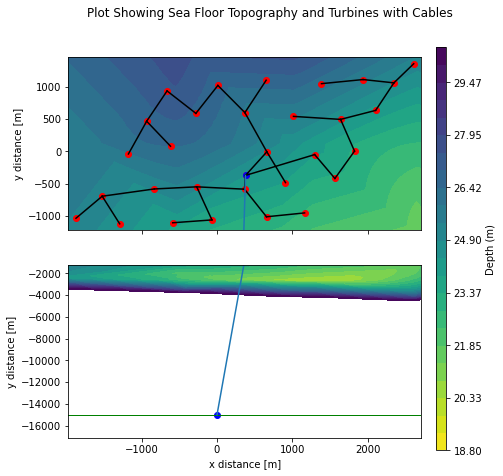

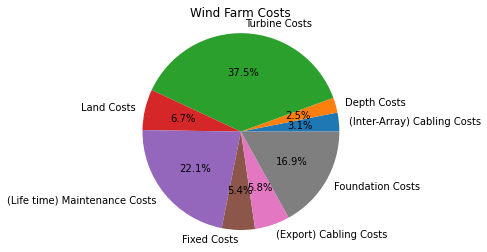

In [65]:
#DISPLAYS OPTIMAL LAYOUT (shows 33 and base)

print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION (ATTENUATION TESTING)'+'\033[0m'+'\033[0m')
print()
OptimizedTPO = smallestTotalCost/smallestCostPerWatt
plotting_function(smallestpositionlist,smallestindiceslist,MSTweight,data,OnshoreSubstation,smallestExportDistance)
OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(OptimizedTPO,smallestTotalCost,smallestpositionlist)

print('\033[1m'+'Total Power Output:'+'\033[0m', OptimizedTPO, 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(OptimizedTPO/theoretical_max_power))*100, '%')
print('\033[1m'+'Cost per Watt'+'\033[0m',smallestCostPerWatt,'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [66]:
## SAVE VARIABLE TO FILE FOR USE IN GAUSSIAN CODE
import pickle

optimised_farm_variables = {'smallestpositionlist': smallestpositionlist, 'smallestindiceslist': smallestindiceslist, 'OptimizedTPO': OptimizedTPO, 'smallestTotalCost': smallestTotalCost, 'smallestCostPerWatt': smallestCostPerWatt, 'smallestExportDistance': smallestExportDistance, 'MSTWeightSum':MSTWeightSum}
with open('optimised_farm_variables.pkl', 'wb') as f:
    pickle.dump(optimised_farm_variables, f)

In [67]:
# 8 turbines produce 6MW of output, which is 37.5% of their max output, which is roughly correct.
# If the wind speed decreases by half, power production decreases by a factor of eight.
# On average, therefore, wind turbines do not generate near their capacity.
# Industry estimates project an annual output of 30-40%, but real-world experience shows that
# annual outputs of 15-30% of capacity are more typical in a year. Therefore this improved 37.5% is good.

In [68]:
print(res.success) # whether the minization was succesful or not
print(res.status) # termination status
print(res.message) # Description of the cause of termination
print(res.nit) # number of iterations performed by the optimizer

True
0
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
12
